In [487]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) #Using this to avoid clustering in outputs
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [488]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Theme:
The cat tries to move the cell up, down, top, bottom. Cats are scared of water, so it takes penalty if cat enters cell with water. It takes small reward if it enters cell with milk and gets some energy. And the goal here is to enter the cell with Fish with maximum reward.

In [489]:
class GridEnvironment(gym.Env):
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.water_pos = ([[0, 2], [2, 3]])
        self.milk_pos = ([[3, 2], [2, 0], [1, 2]])
        self.used_milk = list()
        self.goal_pos = [3, 3]
        self.reward = 0

    def reset(self):
        self.reward = 0
        self.used_milk = list()
        self.milk_pos = ([[3, 2], [3, 0], [1, 2]])
        self.agent_pos = [0, 0]
        observation = self.agent_pos
        self.timestep = 0

        return observation[0] * 4 + observation[1] 

    def step(self, action):
        if action == 0: #right
            self.agent_pos[0] += 1
        if action == 1: #left
            self.agent_pos[0] -= 1
        if action == 2: #up
            self.agent_pos[1] += 1
        if action == 3: #down
            self.agent_pos[1] -= 1

        truncated = False if np.all((self.agent_pos[0] >= 0) & (self.agent_pos[0] <= 3) & (self.agent_pos[1] >= 0) & (self.agent_pos[1] <= 3)) else True
        self.agent_pos = np.clip(self.agent_pos, 0, 3) 
        reward = 0
        used_milk_pos = False
        if np.array_equal(self.agent_pos, self.goal_pos):
            self.reward += 3
            reward = 3
        elif any(np.array_equal(self.agent_pos, pos) for pos in self.milk_pos):
            self.reward += 0.5
            reward = 0.5
            used_milk_pos = True
            # self.used_milk.append(self.agent_pos)
        elif any(np.array_equal(self.agent_pos, pos) for pos in self.water_pos):
            self.reward = self.reward - 1
            reward = -1

        terminated = True if (self.timestep >= self.max_timesteps or np.array_equal(self.agent_pos, self.goal_pos)) else False
         
        self.timestep += 1
        if truncated:
            self.reward = self.reward - 0.1
            reward = -0.1

        return self.agent_pos[0] * 4 + self.agent_pos[1], reward, terminated, truncated, used_milk_pos, self.agent_pos

    def render(self):     
        _, axes = plt.subplots(figsize=(6, 6))
        axes.set_xlim(0, 4)
        axes.set_ylim(0, 4)

        coordinates = {}
        for box in range(16):
            coordinates[box] = np.asarray([box % 4, int(np.floor(box / 4))])
        
        for position in coordinates:
            self.plot_image(coordinates[position], axes)

        plt.xticks([0, 1, 2, 3])
        plt.yticks([0, 1, 2, 3])
        plt.grid()
        plt.show()
        

    def plot_image(self, plot_pos, axes):
        plot_cat, plot_water, plot_milk, plot_fish, plot_used_milk = False, False, False, False, False

        if np.array_equal(self.agent_pos, plot_pos):
            plot_cat = True
        if any(np.array_equal(self.water_pos[i], plot_pos) for i in range(len(self.water_pos))):
            plot_water = True
        if np.array_equal(plot_pos, self.goal_pos):
            plot_fish = True
        if any(np.array_equal(self.milk_pos[i], plot_pos) for i in range(len(self.milk_pos))):
            plot_milk = True
        if any(np.array_equal(self.used_milk[i], plot_pos) for i in range(len(self.used_milk))):
            plot_used_milk = True

        plot_array = np.add(plot_pos, [0.5, 0.5])

        def annotation_box(path):
           return AnnotationBbox(OffsetImage(plt.imread(path), zoom=0.191), plot_array, frameon=False)

        if plot_cat and not plot_water and not plot_milk and not plot_fish and not plot_used_milk: #Cat
            axes.add_artist(annotation_box("./images/cat.jpg"))
        elif plot_water and not plot_cat and not plot_milk and not plot_fish and not plot_used_milk: #Water
            axes.add_artist(annotation_box("./images/water.jpg"))
        elif plot_milk and not plot_cat and not plot_water and not plot_fish and not plot_used_milk: #Milk
            axes.add_artist(annotation_box("./images/milk.jpg"))
        elif plot_fish and not plot_cat and not plot_water and not plot_milk and not plot_used_milk: #Fish
            axes.add_artist(annotation_box("./images/fish.jpg"))
        elif plot_cat and plot_water and not plot_milk and not plot_fish and not plot_used_milk: #Cat and Water
            axes.add_artist(annotation_box("./images/cat_water.jpg"))
        elif plot_cat and plot_milk and not plot_water and not plot_fish and not plot_used_milk: #Cat and Milk
            axes.add_artist(annotation_box("./images/cat_milk.jpg"))
        elif plot_cat and plot_fish and not plot_milk and not plot_water and not plot_used_milk: #Cat and Fish
            axes.add_artist(annotation_box("./images/cat_fish.jpg"))
        elif plot_used_milk and plot_cat and not plot_milk and not plot_water and not plot_fish: #Cat and Fish
            axes.add_artist(annotation_box("./images/cat_no_milk.jpg"))
        elif plot_used_milk and not plot_milk and not plot_water and not plot_fish and not plot_cat: #No Milk
            axes.add_artist(annotation_box("./images/no_milk.jpg"))
        else:
            axes.add_artist(annotation_box("./images/plain.jpg")) #Plain Background
    
    def clear_used_milk(self): #For removing milk once cat drank
        new_milk_pos = []
        for position in self.milk_pos:
            used = False
            for used_position in self.used_milk:
                if np.all(position == used_position):
                    used = True
                    break
            if not used:
                new_milk_pos.append(position)
        self.milk_pos = new_milk_pos

In [490]:
class RandomAgent: 
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self):
    return np.random.choice(self.action_space.n)

Original


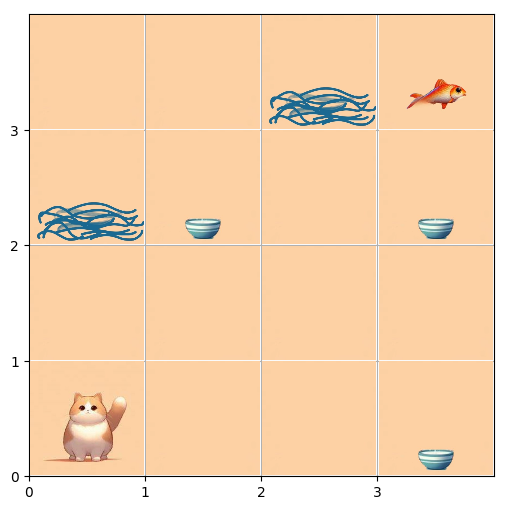

Action: 1 Left , Reward:  -0.1 , Truncated:  True , Done: False


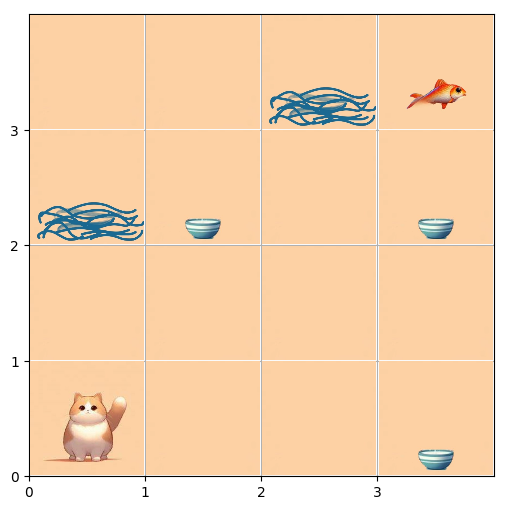

Action: 2 Up , Reward:  0 , Truncated:  False , Done: False


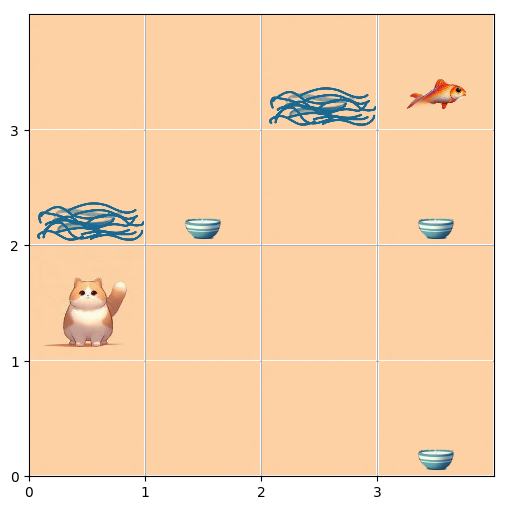

Action: 0 Right , Reward:  0 , Truncated:  False , Done: False


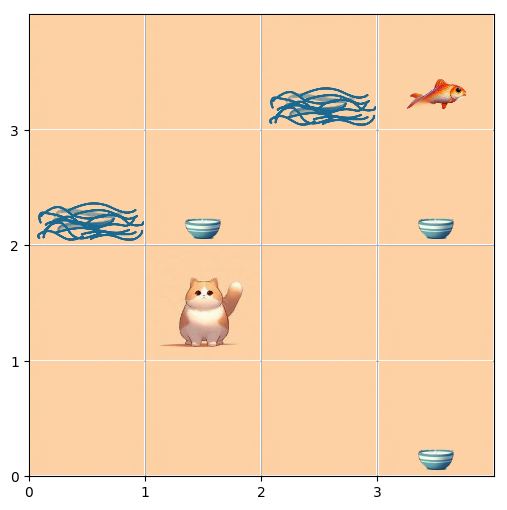

Action: 1 Left , Reward:  0 , Truncated:  False , Done: False


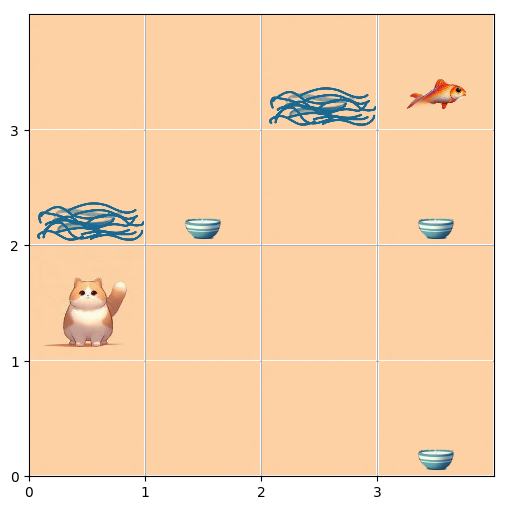

Action: 2 Up , Reward:  -1 , Truncated:  False , Done: False


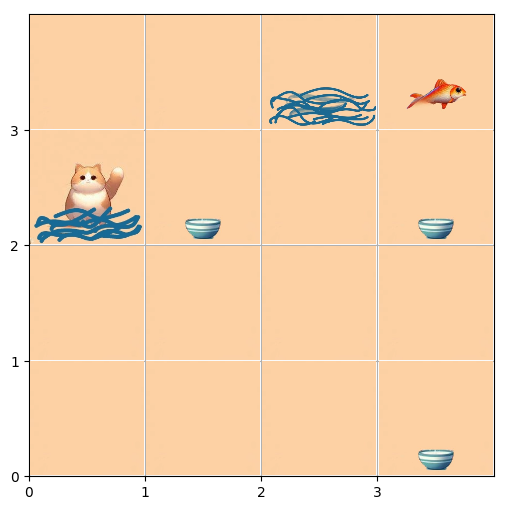

Action: 1 Left , Reward:  -0.1 , Truncated:  True , Done: False


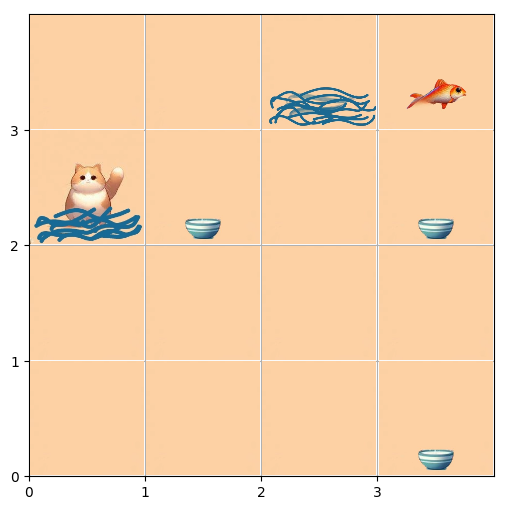

Action: 1 Left , Reward:  -0.1 , Truncated:  True , Done: False


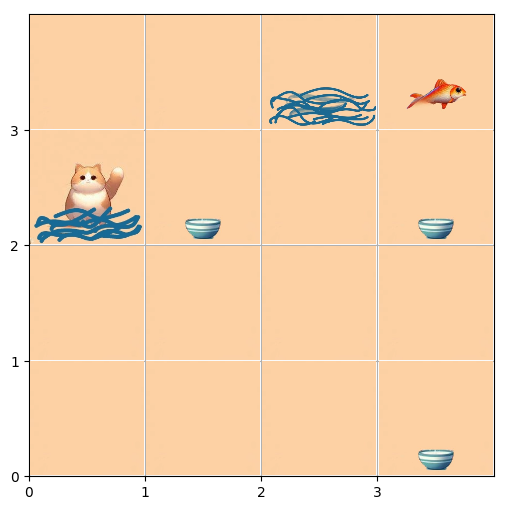

Action: 0 Right , Reward:  0.5 , Truncated:  False , Done: False


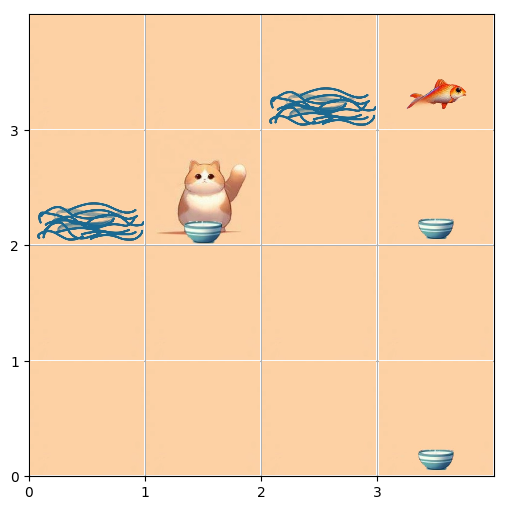

Action: 0 Right , Reward:  0 , Truncated:  False , Done: False


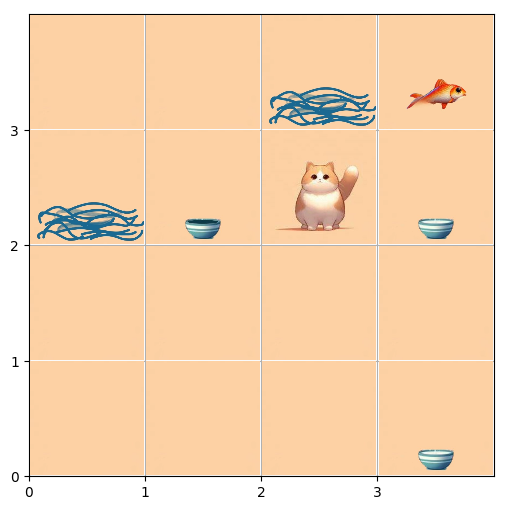

Action: 2 Up , Reward:  -1 , Truncated:  False , Done: False


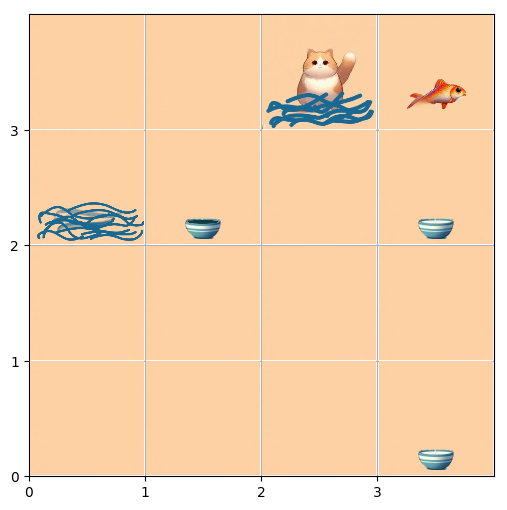

Action: 3 Down , Reward:  0 , Truncated:  False , Done: True


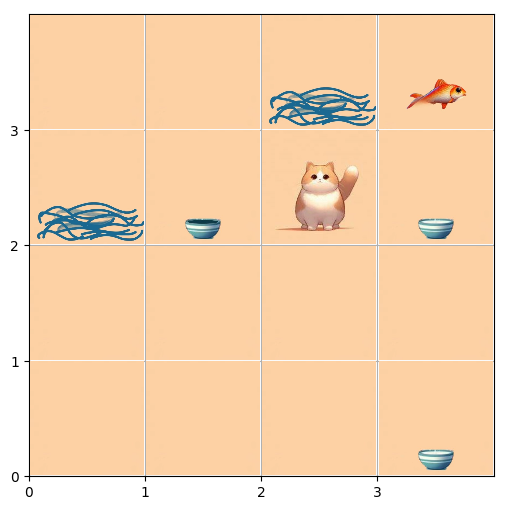

Total reward:  -3.8000000000000003


In [513]:
env = GridEnvironment()
agent = RandomAgent(env)

obs = env.reset()
terminated, truncated = False, False

print("Original")
env.render()
prev_pos = env.agent_pos

while not terminated:
    action = agent.step()
    obs1, reward, terminated, truncated, used_milk_pos, agent_pos = env.step(action)

    move = None
    if action == 0: 
        move = "Right"
    elif action == 1: 
        move = "Left"
    elif action == 2:
        move = "Up"
    else:
        move = "Down"

    print("Action:", action, move, ", Reward: ", reward, ", Truncated: ", truncated, ", Done:", terminated)
    env.render()
    if used_milk_pos and not np.any([np.array_equal(prev_pos, item) for item in env.used_milk]):
        env.used_milk.append(prev_pos)
    env.clear_used_milk()
    prev_pos = agent_pos

print("Total reward: ", env.reward)

*Part 2: SARSA*

In [492]:
class SARSA():
    def __init__(self, senv, max_episodes, gamma, decay_rate, epsilon_max, epsilon_min, alpha):
        self.env = senv
        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.gamma = gamma
        self.alpha = alpha  
        self.epsilon = epsilon_max
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.max_episodes = max_episodes 
        self.decay_rate = decay_rate
        self.rewards = []
        self.epsilons = []
        self.penalties = []

    def get_action(self, observation):
        if np.random.rand() > self.epsilon:
            return np.argmax(self.Q[observation, :])
        else:
            return np.random.choice(self.env.action_space.n)
    def learn(self):
        for _ in range(self.max_episodes):
            obs = self.env.reset()
            action = self.get_action(obs)
            terminated, _ = False, False
            reward_per_episode = 0
            penalty = 0
            reward = 0
            prev_pos = self.env.agent_pos
            while not terminated:
                next_obs, reward, terminated, _, used_milk_pos, agent_pos = self.env.step(action)
                self.env.clear_used_milk()
                reward_per_episode = reward_per_episode + reward
                if reward < 0:
                    penalty += 1
                next_action = self.get_action(next_obs)
                # print(next_action)
                curr_q = self.Q[obs, action]
                next_q = self.Q[next_obs, next_action]
                self.Q[obs, action] += self.alpha * (reward + self.gamma * next_q - curr_q)
                obs = next_obs
                action = next_action 
                self.epsilon = max(self.epsilon_min, self.epsilon * self.decay_rate)
                self.epsilons.append(self.epsilon)
                if used_milk_pos and not np.any([np.array_equal(prev_pos, item) for item in self.env.used_milk]):
                    self.env.used_milk.append(prev_pos)
                self.env.clear_used_milk()
                prev_pos = agent_pos
            self.rewards.append(reward_per_episode)       
            self.penalties.append(penalty)

In [515]:
def run_sarsa(max_episodes, gamma, decay_rate, epsilon_max, epsilon_min, alpha, max_timesteps):
    senv = GridEnvironment()
    senv.max_timesteps = max_timesteps
    s_agent = SARSA(senv=senv, max_episodes=max_episodes, gamma=gamma, decay_rate=decay_rate, epsilon_max=epsilon_max, epsilon_min=epsilon_min, alpha=alpha)
    print("Q-Table Before Training: ")
    print(s_agent.Q)
    s_agent.learn()
    print("Q-Table After Training: ")
    print(s_agent.Q)
    obs = senv.reset()
    terminated, _ = False, False

    print("Original:")
    senv.render()
    prev_pos = senv.agent_pos
    test_rewards = []
    test_reward = 0
    penalties = 0
    while not terminated:
        action = s_agent.get_action(obs)
        obs, reward, terminated, truncated, used_milk_pos, agent_pos = senv.step(action)
        test_rewards.append(reward)
        test_reward += reward
        if reward < 0:
            penalties +=1
        move = None
        if action == 0: 
            move = "Right"
        elif action == 1: 
            move = "Left"
        elif action == 2:
            move = "Up"
        else:
            move = "Down"
        print("Action:", action, move, ", Reward:", reward, "Truncated: ", truncated, ", Done:", terminated)
        # senv.render()
        if used_milk_pos and not np.any([np.array_equal(prev_pos, item) for item in senv.used_milk]):
            senv.used_milk.append(prev_pos)
        senv.clear_used_milk()
        prev_pos = agent_pos
    
    print("At the End:")
    senv.render() 

    print("Total reward during Training: ", senv.reward)
    print("Total Rewards during Testing: ", test_reward)

    plt.figure()
    plt.plot(s_agent.rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Per Episode (Training)')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(s_agent.epsilons)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay')
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=500)
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(test_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward Per Episode (Testing)')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(s_agent.penalties)
    plt.xlabel('Episode')
    plt.ylabel('penalty')
    plt.title('Cumulative penalty Per Episode (Training)')
    plt.grid()
    plt.show()

    print("Average of Training penalties: ", sum(s_agent.penalties)/len(s_agent.penalties))

    print("Test Penalties: ", penalties)

    return s_agent

Q-Table Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table After Training: 
[[ 2.14615905e+00  1.01035548e+00  5.56553572e-01  7.29257171e-01]
 [ 1.89127847e+00  8.68714587e-02 -1.76073744e-01  1.60301763e-01]
 [ 1.23523375e+00 -1.11093307e-02 -2.08733429e-03  7.15164354e-02]
 [ 8.00855012e-02 -9.75000000e-03 -9.75000000e-03 -9.43502699e-02]
 [ 1.74741865e-01  1.06752395e+00  2.41114660e+00  9.72236301e-01]
 [ 5.82408839e-01  8.67264737e-01  2.78039770e+00  1.27519059e+00]
 [ 2.69284773e+00 -4.68237448e-01  6.24946479e-01  1.41661267e+00]
 [-2.56261496e-01  1.34142608e-03 -1.11034980e-02  1.54170972e+00]
 [ 2.89664435e-01  2.33572931e-01  2.68414240e-04 -2.18335538e-02]
 [ 1.25868372e-02  1.73688119e+00  2.95406343e-01  3.12332617e-02]
 [ 3.12512375e+00  1.63620413e+00 -1.5

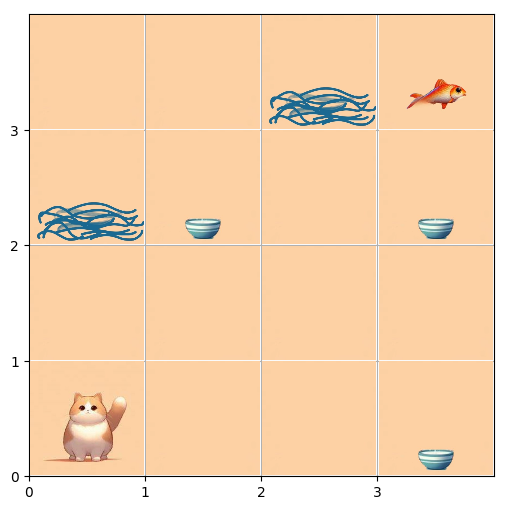

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


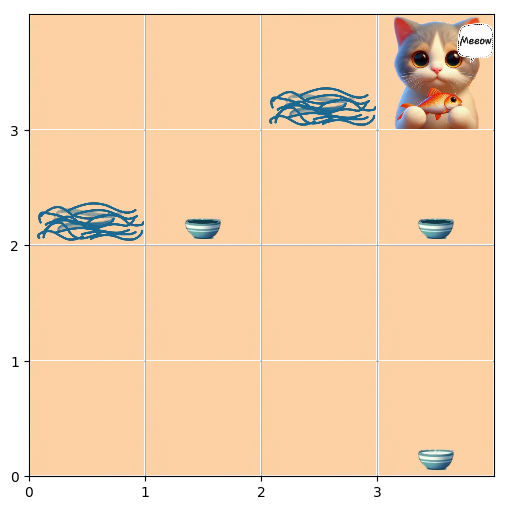

Total reward during Training:  4.0
Total Rewards during Testing:  4.0


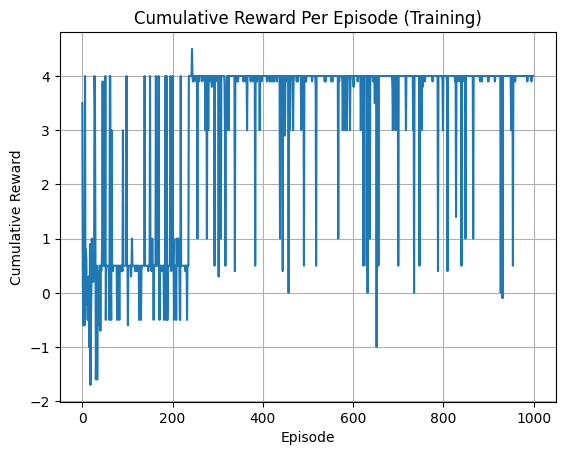

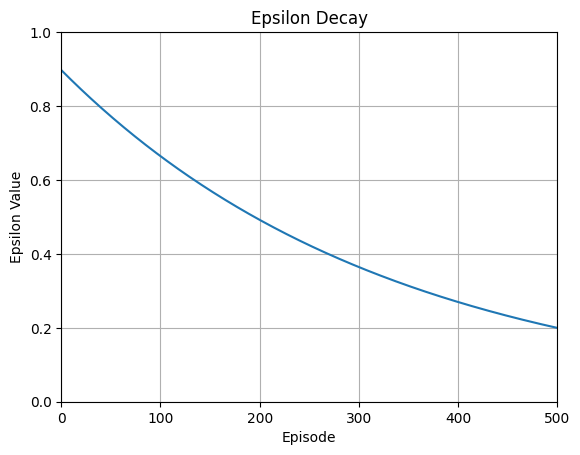

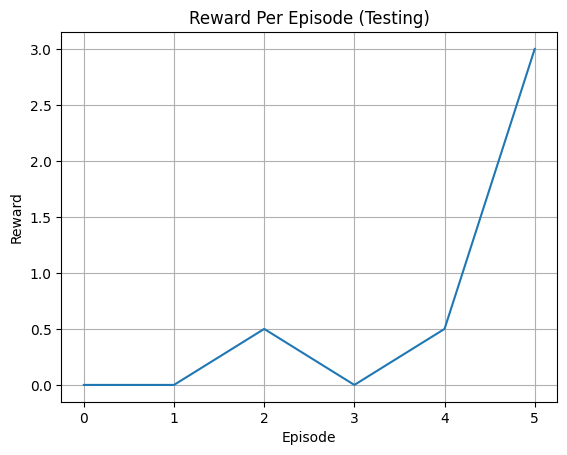

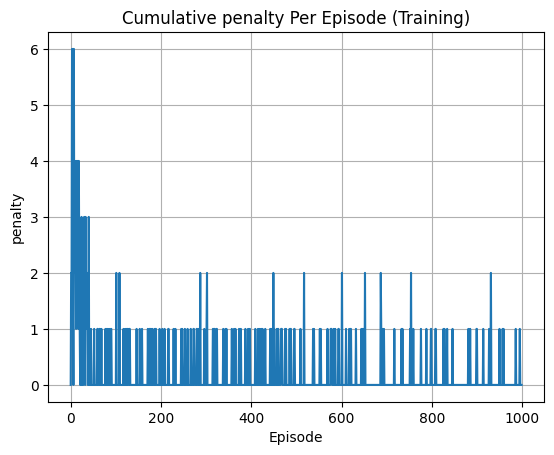

Average of Training penalties:  0.238
Test Penalties:  0


In [494]:
sarsa = run_sarsa(max_episodes=1000, gamma=0.9, decay_rate=0.997, epsilon_max=0.9, epsilon_min=0.1, alpha=0.05, max_timesteps=10)

Tuning Epsilon min/max values -- 1

Q-Table Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table After Training: 
[[ 4.00885442e-01 -1.48559433e-02  0.00000000e+00  2.74041072e-02]
 [ 7.96723200e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -8.00000000e-03  0.00000000e+00]
 [ 4.47748436e-01  2.62863050e-02  8.17920000e-03  6.50704559e-02]
 [ 0.00000000e+00  0.00000000e+00  1.41803520e-01 -5.76000000e-04]
 [-5.76000000e-03 -8.00000000e-02  0.00000000e+00  0.00000000e+00]
 [-4.68224000e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.02755825e-01  3.30476558e-01  2.18806918e-01  2.50231230e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.22318738e-01]
 [ 0.00000000e+00  0.00000000e+00 -1.3

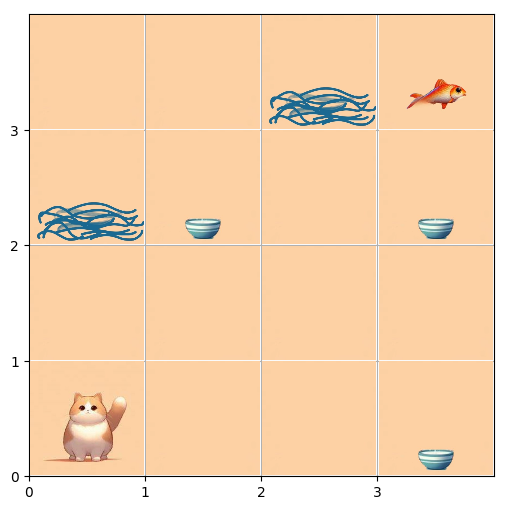

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: True
At the End:


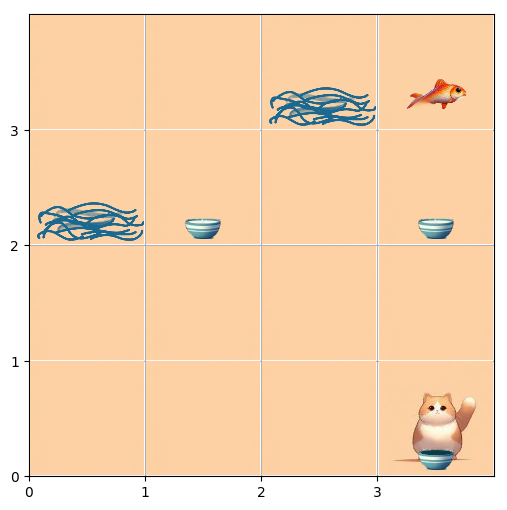

Total reward during Training:  0.5
Total Rewards during Testing:  0.5


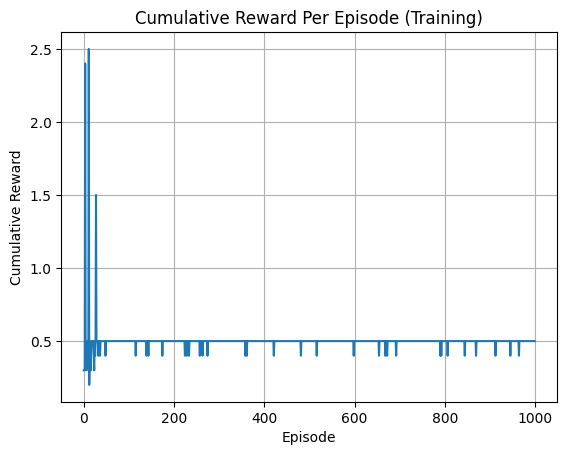

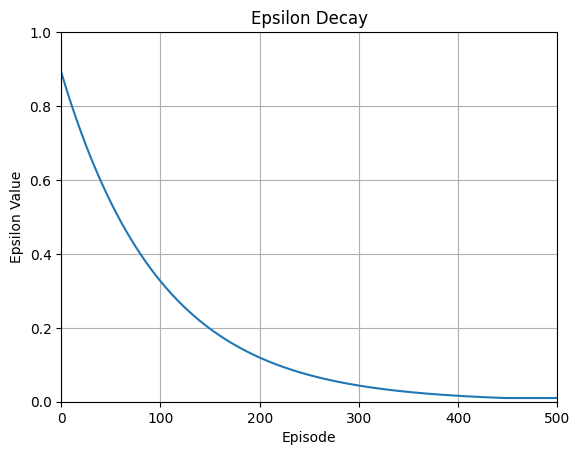

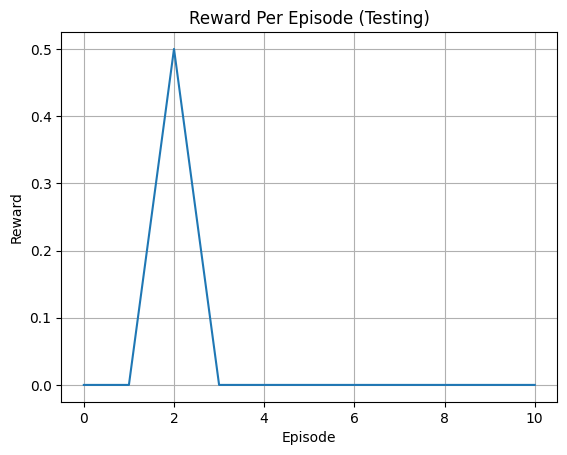

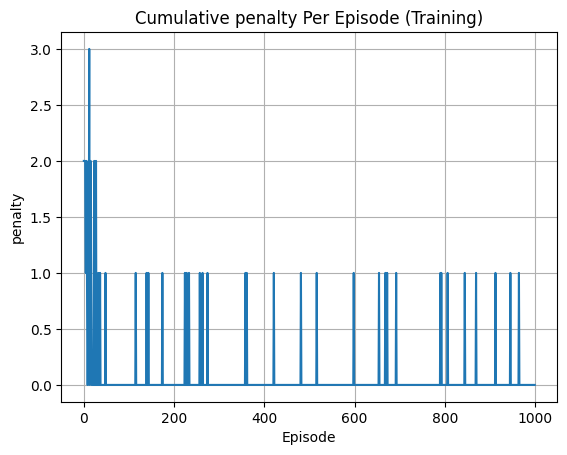

Average of Training penalties:  0.059
Test Penalties:  0


In [495]:
sarsa1 = run_sarsa(max_episodes=1000, gamma=0.9, decay_rate=0.99, epsilon_max=0.9, epsilon_min=0.01, alpha=0.08, max_timesteps=10)

Tuning Epsilon min/max values -- 2 

Q-Table Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table After Training: 
[[ 2.11366136e+00  1.41765441e+00  6.21063071e-01  1.42178443e+00]
 [ 1.23518681e+00 -1.02858844e-02 -4.57722875e-01  3.69685939e-01]
 [ 3.20461512e-01 -1.85119615e-02  0.00000000e+00  1.34362224e-02]
 [ 4.05069231e-03 -1.53600000e-02  0.00000000e+00 -7.65535908e-02]
 [ 2.37584666e+00  1.52351108e+00  1.54547172e+00  1.93183677e+00]
 [ 7.71362082e-01  1.44761452e-01  5.97567509e-01  1.99779944e+00]
 [ 3.75219891e-02 -5.03066696e-01  7.17758949e-03  1.07794327e+00]
 [-8.00000000e-02 -5.76000000e-04 -8.00000000e-03  1.19247340e-01]
 [ 2.82043554e+00  1.85582907e+00  1.64340703e+00  2.26764388e+00]
 [ 4.40352463e-01  2.14021448e-01  4.44928628e-01  2.23689711e+00]
 [ 2.61680385e+00  1.91228886e-01 -6.2

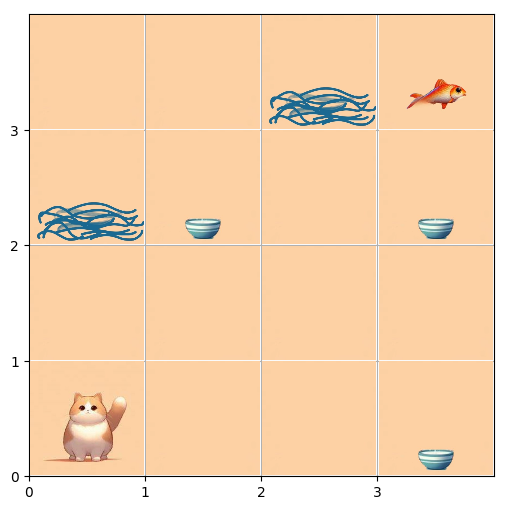

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


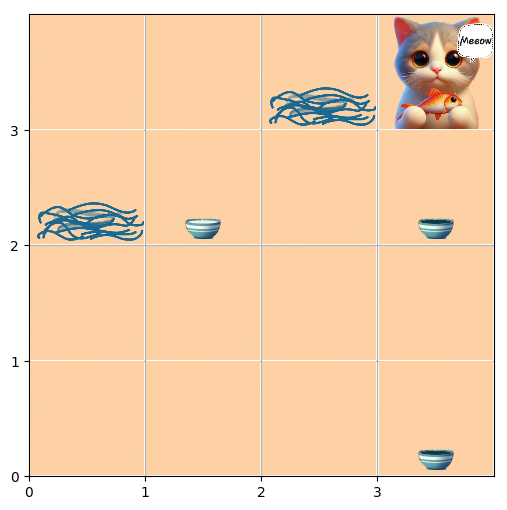

Total reward during Training:  4.0
Total Rewards during Testing:  4.0


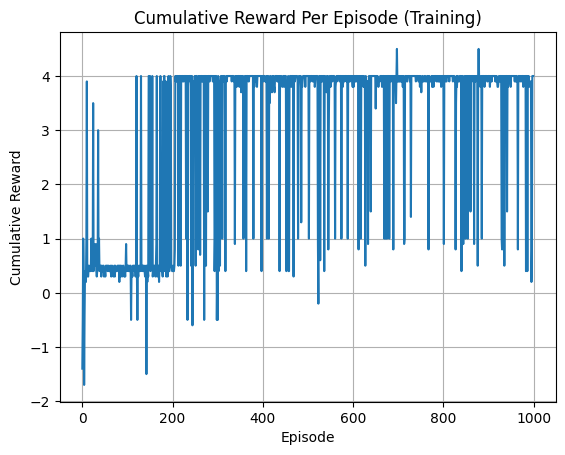

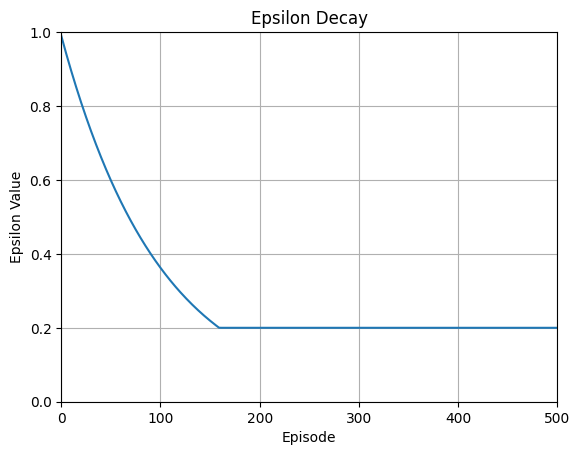

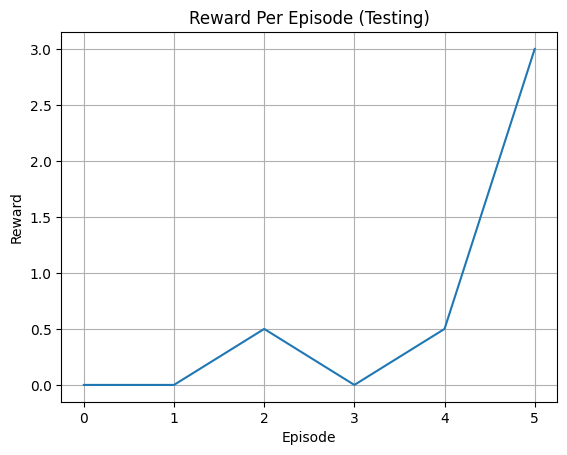

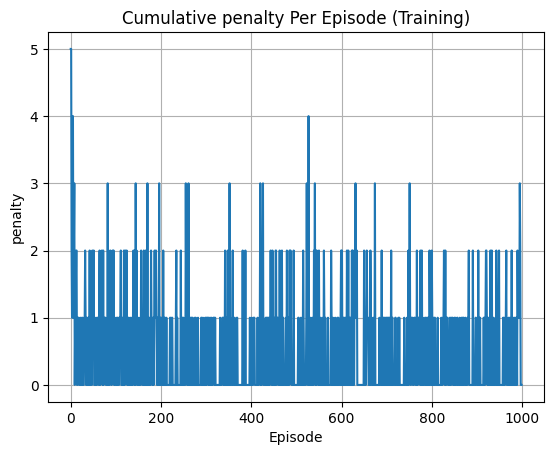

Average of Training penalties:  0.538
Test Penalties:  0


In [496]:
sarsa2 = run_sarsa(max_episodes=1000, gamma=0.9, decay_rate=0.99, epsilon_max=1, epsilon_min=0.2, alpha=0.08, max_timesteps=10)

Tuning Epsilon min/max values -- 3

Q-Table Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table After Training: 
[[ 0.40203494  0.08541587  0.0126754   0.03055945]
 [ 0.24793944  0.         -0.15173096  0.        ]
 [ 0.22360371 -0.00595064  0.          0.        ]
 [ 0.          0.         -0.008      -0.07710507]
 [ 0.00288     0.11698849  0.44935891  0.00667783]
 [ 0.03746576  0.07344945  0.50502096  0.18147864]
 [ 0.05131938 -0.56958483  0.04514136  0.46922871]
 [-0.1536      0.         -0.008       0.20366468]
 [ 0.06183461  0.          0.         -0.008     ]
 [ 0.15904001  0.          0.          0.        ]
 [ 0.04        0.20779046 -0.1536      0.        ]
 [ 0.24        0.          0.          0.        ]
 [-0.01536     0.0141464   0.          0.        ]
 [-0.01536     0.          0.59926877  0.    

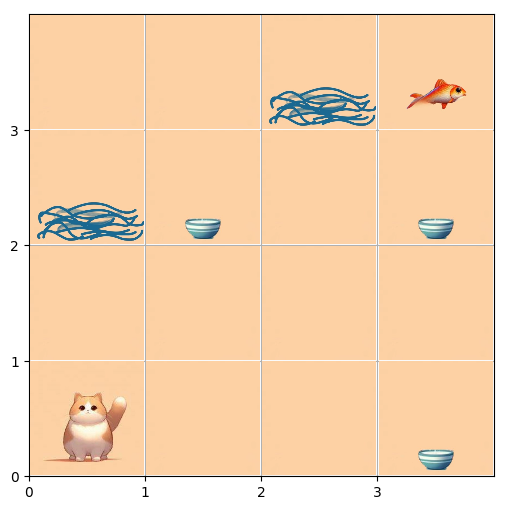

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 3 Down , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 3 Down , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 3 Down , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 3 Down , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: True
At the End:


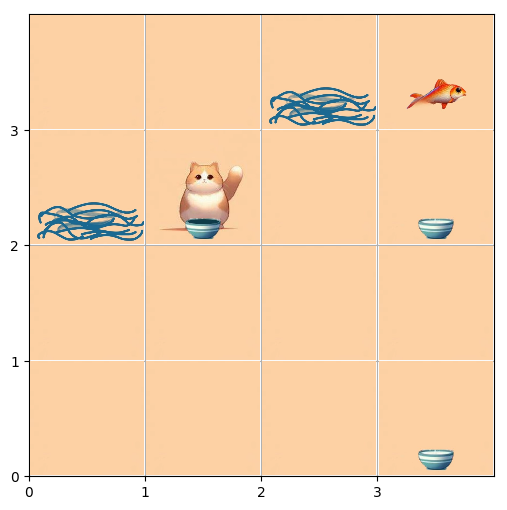

Total reward during Training:  0.5
Total Rewards during Testing:  0.5


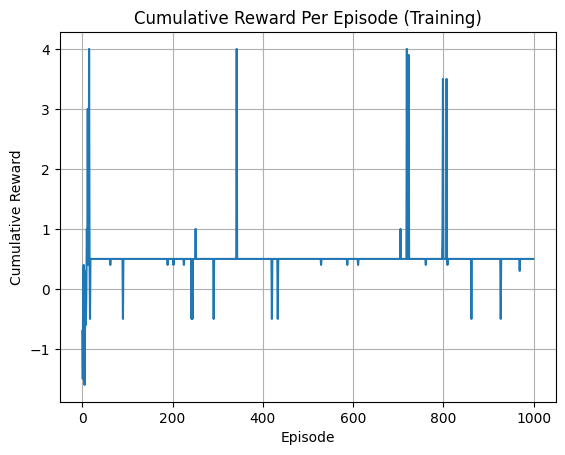

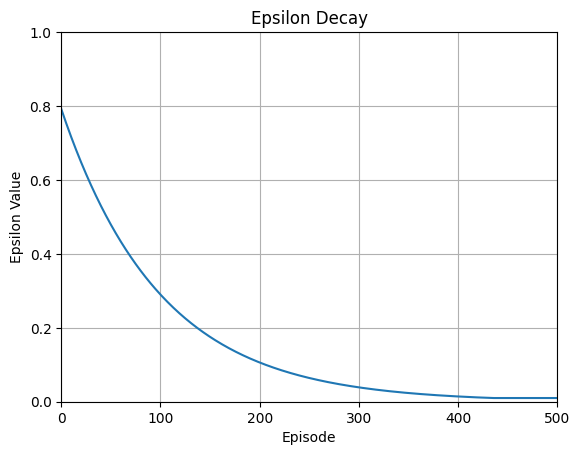

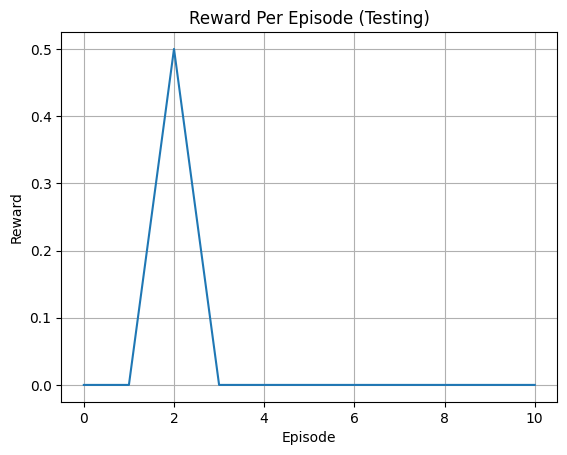

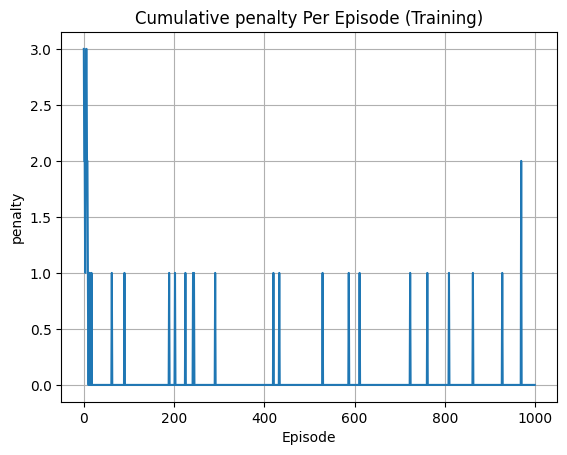

Average of Training penalties:  0.044
Test Penalties:  0


In [497]:
sarsa3 = run_sarsa(max_episodes=1000, gamma=0.9, decay_rate=0.99, epsilon_max=0.8, epsilon_min=0.01, alpha=0.08, max_timesteps=10)

Tuning Max Time Steps -- 1

Q-Table Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table After Training: 
[[ 1.98522629e+00  1.56937674e+00  1.32741909e+00  1.34441385e+00]
 [ 2.26152941e+00 -2.76421446e-02 -2.78793633e-01  0.00000000e+00]
 [ 1.71747604e+00  0.00000000e+00 -5.76000000e-04  1.21470570e-01]
 [ 2.88000000e-03 -2.26611200e-02 -8.00000000e-03 -8.00000000e-02]
 [ 1.11408005e+00  1.63742714e+00  2.26744107e+00  1.66866647e+00]
 [ 1.38789577e+00  1.44635325e+00  2.64393230e+00  1.79181048e+00]
 [ 2.73449659e+00  8.59287288e-04  1.28944777e+00  2.05129831e+00]
 [-9.60113521e-02  0.00000000e+00 -8.00000000e-03  2.07358004e+00]
 [ 1.80854817e+00  1.51035995e-01  6.24687046e-04 -3.23782984e-02]
 [ 3.97991222e-01  2.33648015e+00  2.88000000e-03  1.10090327e-01]
 [ 3.10768704e+00  1.62186741e+00  7.9

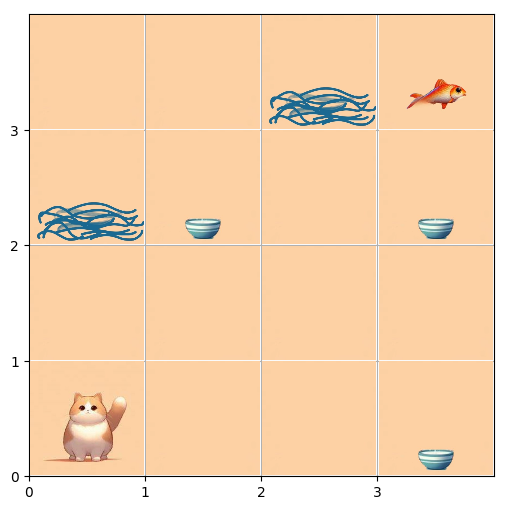

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


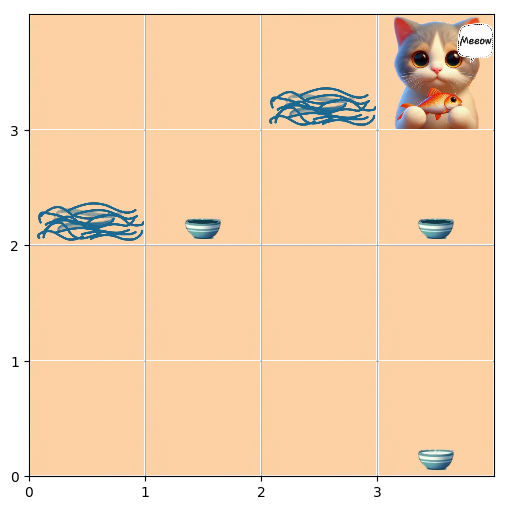

Total reward during Training:  4.0
Total Rewards during Testing:  4.0


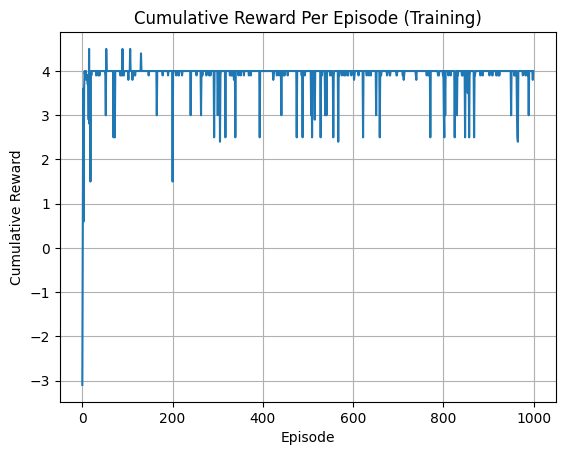

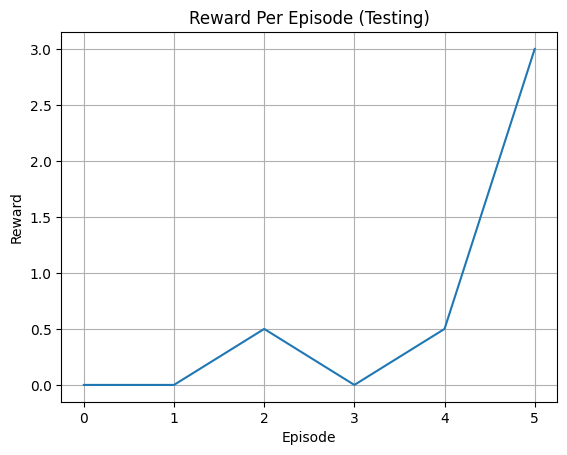

Average of Training penalties:  0.209
Test Penalties:  0


In [516]:
sarsa4 = run_sarsa(max_episodes=1000, gamma=0.9, decay_rate=0.995, epsilon_max=1, epsilon_min=0.1, alpha=0.08, max_timesteps=20)

Tuning max time steps -- 2

Q-Table Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table After Training: 
[[ 2.08044434  1.52210405  1.30192509  1.46926155]
 [ 2.31428258 -0.00425621 -0.03410459  0.25866361]
 [ 2.21588593 -0.01162931  0.          0.        ]
 [-0.00447807 -0.008      -0.02276316 -0.15400049]
 [ 0.4818218   1.41900177  2.4068545   1.67140496]
 [ 1.24409247  1.06602673  2.89068285  1.74487332]
 [ 2.68834708  0.55199457  1.14586313  1.7097769 ]
 [-0.30774088 -0.00668465  0.08247079  1.95764174]
 [ 1.41360232  0.01160603  0.25117298 -0.01821161]
 [ 2.56949723  0.36973844  0.          0.19787958]
 [ 3.17486456  1.52962743  0.91938931  1.6721577 ]
 [ 2.7327189  -0.00350794 -0.00811473  0.22168074]
 [-0.03282929  0.03726589  2.03172647 -0.01446571]
 [ 0.36057573  0.07497592  3.03378346  0.1522

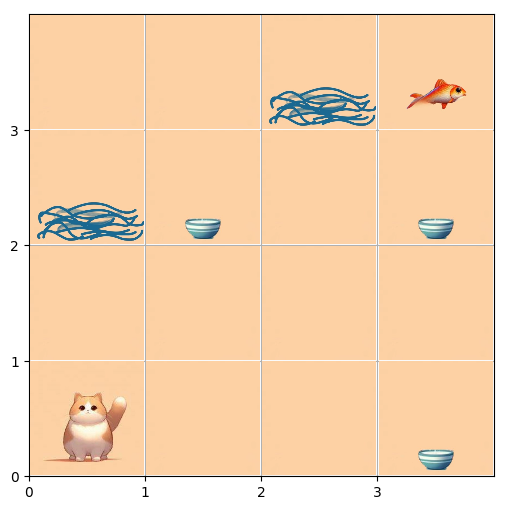

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


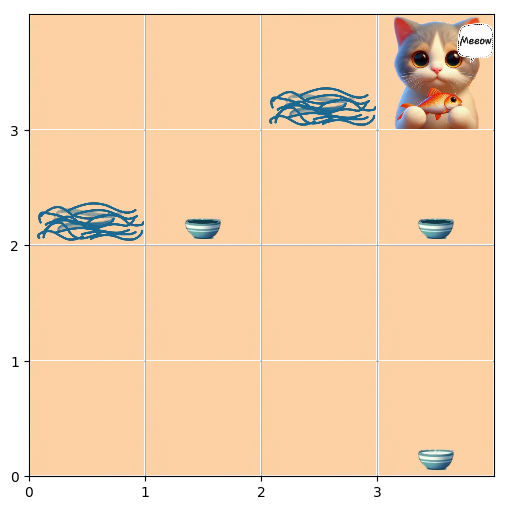

Total reward during Training:  4.0
Total Rewards during Testing:  4.0


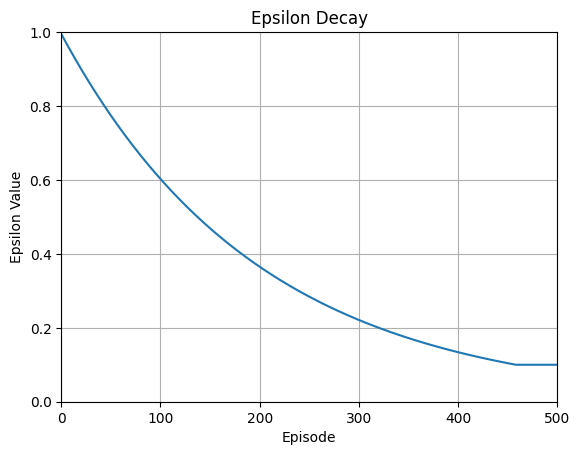

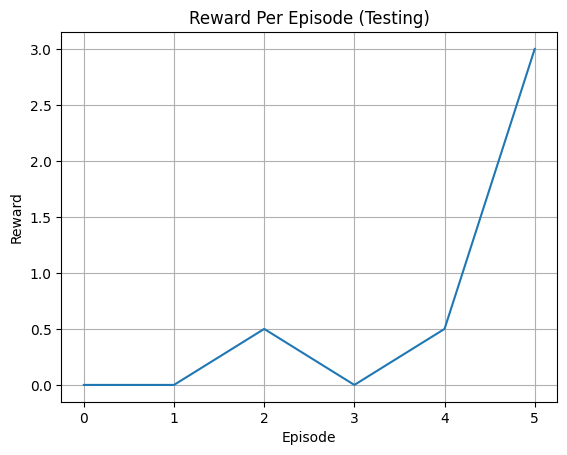

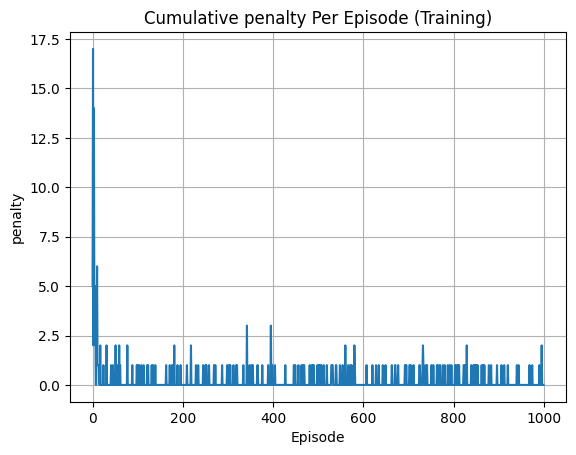

Average of Training penalties:  0.235
Test Penalties:  0


In [499]:
sarsa5 = run_sarsa(max_episodes=1000, gamma=0.9, decay_rate=0.995, epsilon_max=1, epsilon_min=0.1, alpha=0.08, max_timesteps=35)

Tuning max time steps -- 3

Q-Table Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table After Training: 
[[ 1.66041851e+00  1.29034948e+00  2.11350752e+00  1.59383582e+00]
 [ 2.37762339e+00  1.57609188e+00  2.04910988e-01  1.43762520e+00]
 [ 1.84054054e-01  1.13066325e-01 -1.33751283e-02  2.08236186e+00]
 [ 5.91452347e-02 -1.53600000e-02 -8.57600000e-03 -2.19585199e-01]
 [-9.29421538e-04  2.61076185e-01  2.24652223e+00  1.24629123e-01]
 [ 1.71306765e+00  1.81460855e+00  2.73759747e+00  1.48618322e+00]
 [ 2.68742049e+00  6.12068093e-01  1.30868175e+00  2.06252472e+00]
 [-3.78291404e-02 -7.68579011e-04 -1.53600000e-02  2.01551219e+00]
 [ 9.77045974e-02  3.52860389e-05  3.31385698e-03 -3.22362305e-02]
 [ 2.52424733e+00  3.74705604e-01  4.31310137e-01  3.83173975e-02]
 [ 3.09259133e+00  1.61743724e+00  1.0

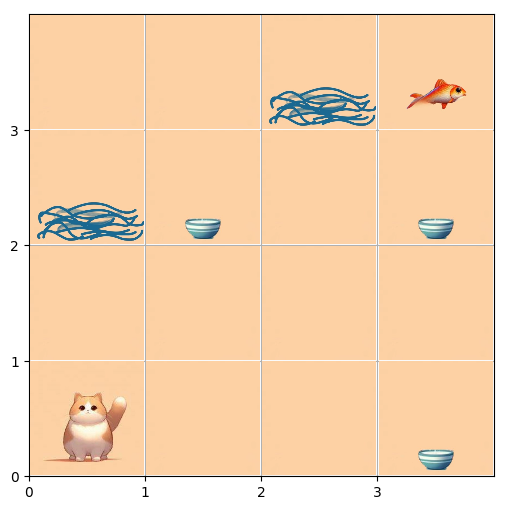

Action: 1 Left , Reward: -0.1 Truncated:  True , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: -0.1 Truncated:  True , Done: False
Action: 2 Up , Reward: -1 Truncated:  False , Done: False
Action: 3 Down , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


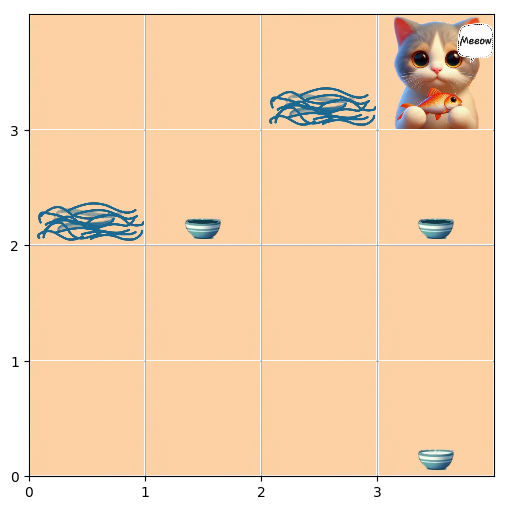

Total reward during Training:  2.8
Total Rewards during Testing:  2.8


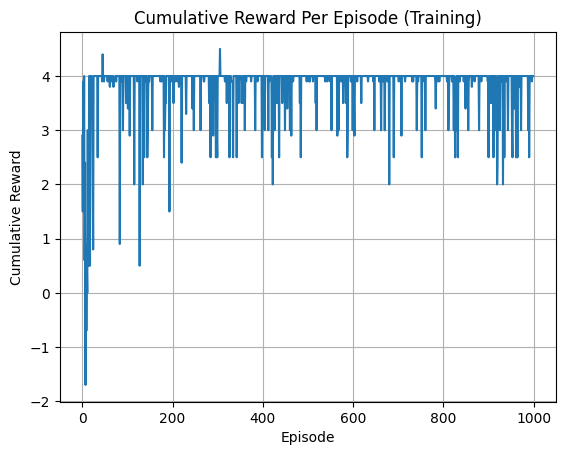

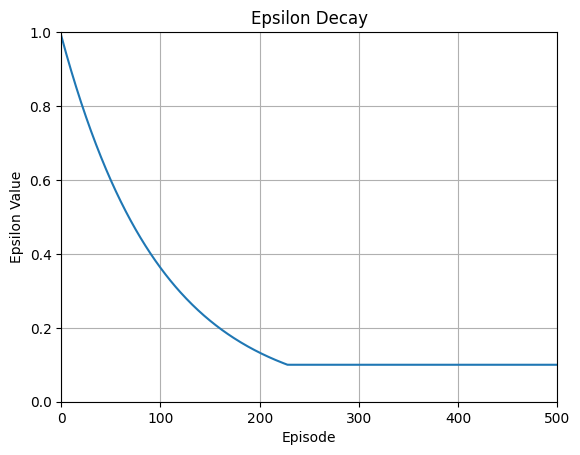

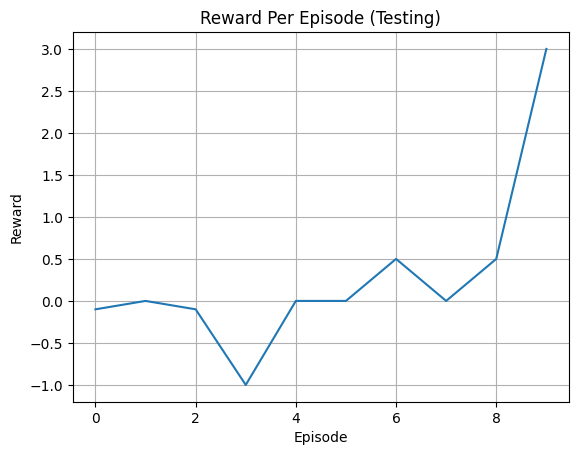

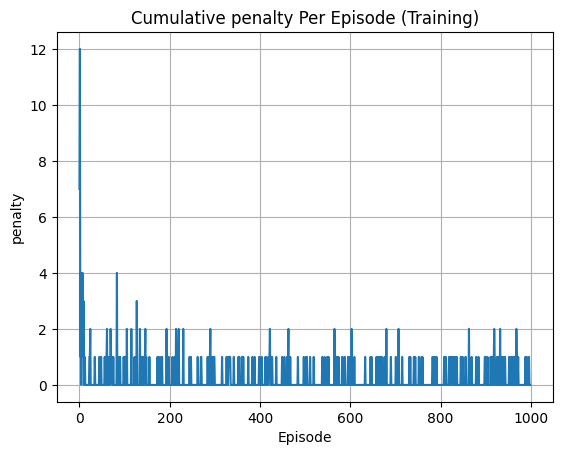

Average of Training penalties:  0.257
Test Penalties:  3


In [500]:
sarsa6 = run_sarsa(max_episodes=1000, gamma=0.9, decay_rate=0.99, epsilon_max=1, epsilon_min=0.1, alpha=0.08, max_timesteps=50)

*Part 3 - Double Q Learning*

In [501]:
class DoubleQLearning():
    def __init__(self, dqlenv, max_episodes, gamma, decay_rate, epsilon_max, epsilon_min, alpha):
        self.env = dqlenv
        self.Q1 = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.Q2 = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.gamma = gamma
        self.alpha = alpha  
        self.epsilon = epsilon_max
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.max_episodes = max_episodes 
        self.decay_rate = decay_rate
        self.rewards = []
        self.epsilons = []
        self.penalties = []

    def get_action(self, observation):
        if np.random.random() > self.epsilon:
            return np.argmax(self.Q1[observation, :] + self.Q2[observation, :])
        else:
            return np.random.choice(self.env.action_space.n)
            
    def learn(self):
        for _ in range(self.max_episodes):
            obs = self.env.reset()
            action = self.get_action(obs)
            terminated, _ = False, False
            reward_per_episode = 0
            penalty = 0
            reward = 0
            prev_pos = self.env.agent_pos
            while not terminated:
                next_obs, reward, terminated, _, _, _ = self.env.step(action)
                self.env.clear_used_milk()
                reward_per_episode = reward_per_episode + reward
                if reward < 0:
                    penalty += 1
                next_action = self.get_action(next_obs)
                if np.random.random() < 0.5:
                    curr_q = self.Q1[obs, action]
                    next_q = self.Q2[next_obs, np.argmax(self.Q1[next_obs, action])]
                    self.Q1[obs, action] += self.alpha * (reward + self.gamma * next_q - curr_q)
                else:
                    curr_q = self.Q2[obs, action]
                    next_q = self.Q1[next_obs, np.argmax(self.Q2[next_obs, action])]
                    self.Q2[obs, action] += self.alpha * (reward + self.gamma * next_q - curr_q)
                obs = next_obs
                action = next_action 
                self.epsilon = max(self.epsilon_min, self.epsilon * self.decay_rate)
                self.epsilons.append(self.epsilon)
                if used_milk_pos and not np.any([np.array_equal(prev_pos, item) for item in self.env.used_milk]):
                    self.env.used_milk.append(prev_pos)
                self.env.clear_used_milk()
                prev_pos = agent_pos
            self.rewards.append(reward_per_episode)
            self.penalties.append(penalty)      

In [533]:
def run_dql(max_episodes, gamma, decay_rate, epsilon_max, epsilon_min, alpha, max_timesteps):
    dqlenv = GridEnvironment()
    dqlenv.max_timesteps = max_timesteps
    dqagent = DoubleQLearning(dqlenv=dqlenv, max_episodes=max_episodes, gamma=gamma, decay_rate=decay_rate, epsilon_max=epsilon_max, epsilon_min=epsilon_min, alpha=alpha)
    print("Q-Table 1 Before Training: ")
    print(dqagent.Q1)
    print("Q-Table 2 Before Training: ")
    print(dqagent.Q2)
    dqagent.learn()
    print("Q-Table 1 After Training: ")
    print(dqagent.Q1)
    print("Q-Table 2 After Training: ")
    print(dqagent.Q2)
    obs = dqlenv.reset()
    terminated, _ = False, False

    print("Original:")
    dqlenv.render()
    prev_pos = dqlenv.agent_pos
    test_rewards = []
    test_reward = 0
    penalties = 0
    while not terminated:
        action = dqagent.get_action(obs)
        obs, reward, terminated, truncated, used_milk_pos, agent_pos = dqlenv.step(action)
        test_reward += reward
        test_rewards.append(reward)
        if reward < 0:
            penalties += 1
        move = None
        if action == 0: 
            move = "Right"
        elif action == 1: 
            move = "Left"
        elif action == 2:
            move = "Up"
        else:
            move = "Down"
        print("Action:", action, move, ", Reward:", reward, "Truncated: ", truncated, ", Done:", terminated)
        # senv.render()
        if used_milk_pos and not np.any([np.array_equal(prev_pos, item) for item in dqlenv.used_milk]):
            dqlenv.used_milk.append(prev_pos)
        dqlenv.clear_used_milk()
        prev_pos = agent_pos
    
    print("At the End:")
    dqlenv.render() 

    print("Total reward (Training): ", dqlenv.reward)

    plt.figure()
    plt.plot(dqagent.rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Per Episode (Training)')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(dqagent.epsilons)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon Value')
    plt.title('Epsilon Decay')
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=500)
    plt.grid()
    plt.show()

    print("Total reward (Testing): ", test_reward)
    
    plt.figure()
    plt.plot(test_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward Per Episode (Testing)')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(dqagent.penalties)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Penalties')
    plt.title('Cumulative Penalties Per Episode (Training)')
    plt.grid()
    plt.show()

    print("Average of Training penalties: ", sum(dqagent.penalties)/len(dqagent.penalties))

    print("Test Penalties: ", penalties)

    return dqagent

Q-Table 1 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 2 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 1 After Training: 
[[ 3.69447111e-01  2.16524263e-02  0.00000000e+00  2.32794016e-02]
 [ 0.00000000e+00 -1.99000000e-03 -3.92703355e-02  3.49304028e-02]
 [ 5.00000000e-03 -1.94500000e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.20472437e-01  2.92892564e-02  0.00000000e+00  2.11835356e-02]
 [ 0.00000000e+00  0.00000000e+00  7.50546000e-02  0.00000000e+00]
 [ 8.58037207e-03  0.00000000e+00

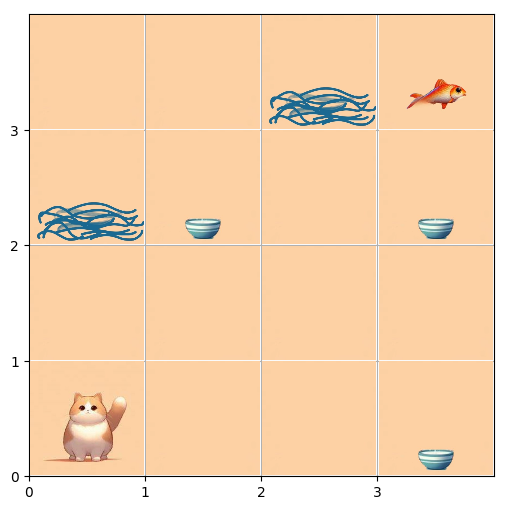

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: -0.1 Truncated:  True , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: True
At the End:


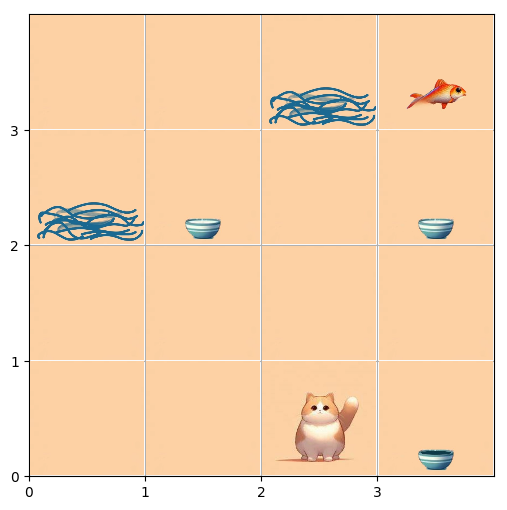

Total reward (Training):  0.4


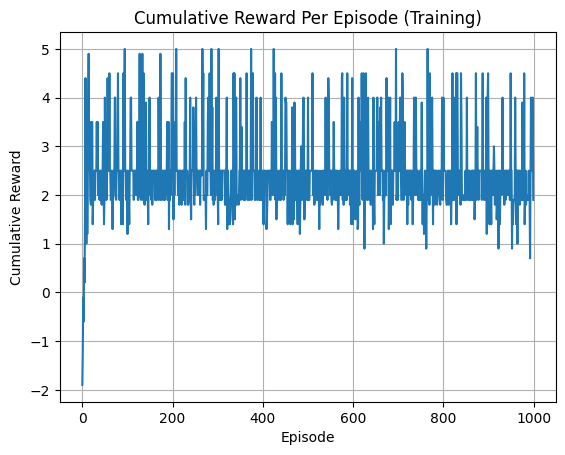

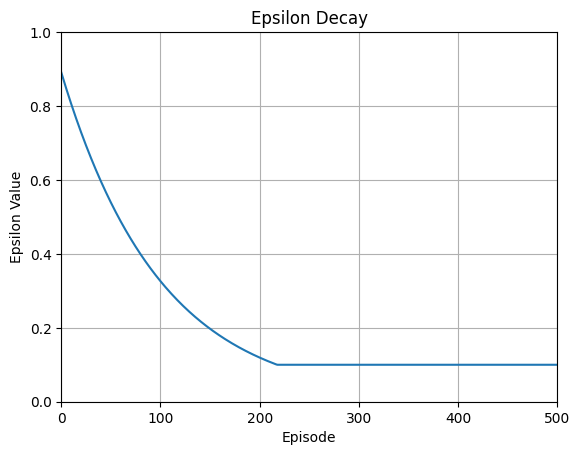

Total reward (Testing):  0.4


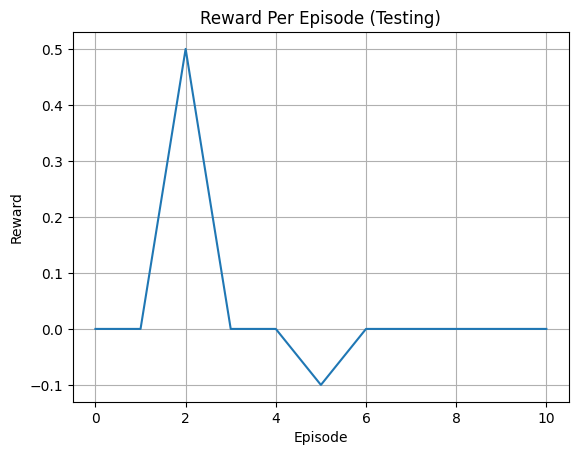

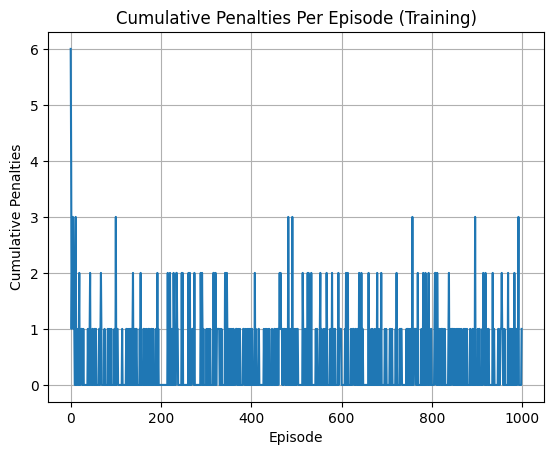

Average of Training penalties:  0.419
Test Penalties:  1


In [503]:
dql = run_dql(max_episodes=1000, gamma=0.9, decay_rate=0.99, epsilon_max=0.9, epsilon_min=0.1, alpha=0.01, max_timesteps=10)

Hyperparameter Tuning 1 -- Epsilon Decay Rate 1

Q-Table 1 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 2 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 1 After Training: 
[[ 3.66190006e-01  1.28599426e-02  0.00000000e+00  1.32760711e-02]
 [-1.45071000e-09 -1.00000000e-03 -1.00000000e-02  4.54742821e-02]
 [ 5.00000000e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.19001651e-01  3.51527625e-02 -1.51833841e-08  3.92094537e-02]
 [-1.65498754e-07  0.00000000e+00  6.22295386e-02  0.00000000e+00]
 [ 1.64451907e-02 -9.95500000e-03

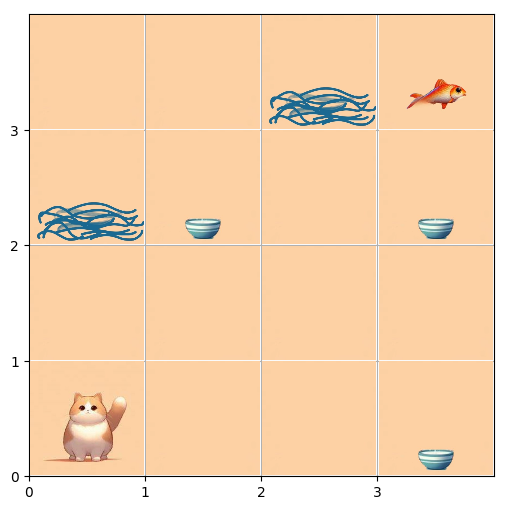

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: -0.1 Truncated:  True , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


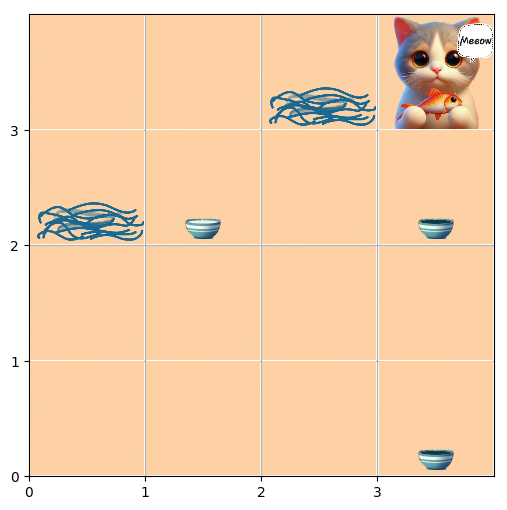

Total reward (Training):  3.9


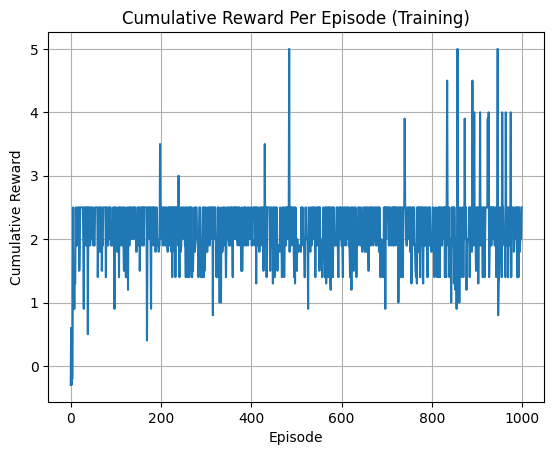

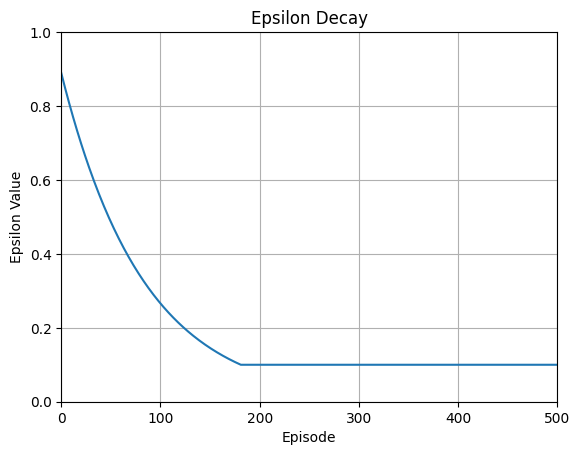

Total reward (Testing):  3.9


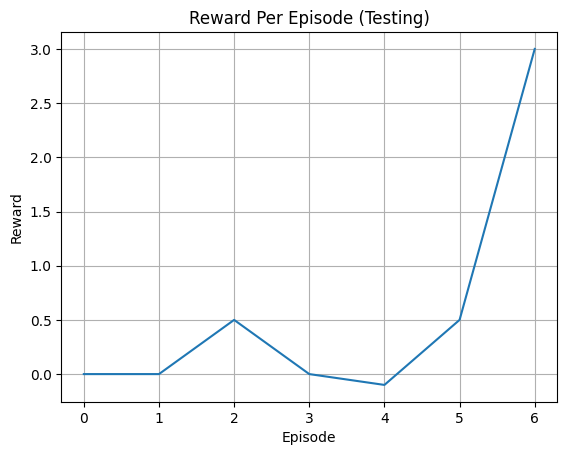

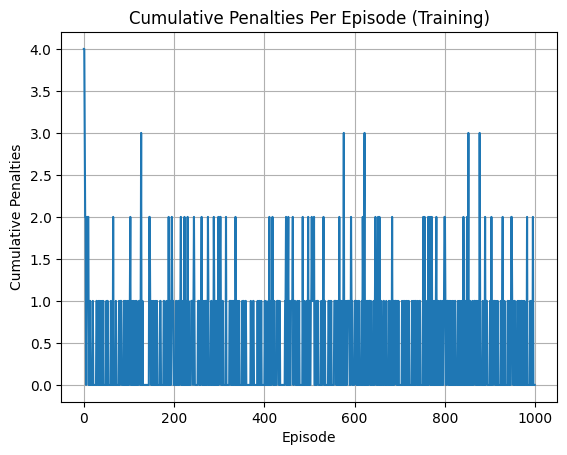

Average of Training penalties:  0.448
Test Penalties:  1


In [504]:
dql1 = run_dql(max_episodes=1000, gamma=0.9, decay_rate=0.988, epsilon_max=0.9, epsilon_min=0.1, alpha=0.01, max_timesteps=10)

Hyperparameter Tuning 2 -- Epsilon Decay Rate 2

Q-Table 1 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 2 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 1 After Training: 
[[ 3.61697566e-01  1.03508776e-02 -3.89419140e-10  1.43180674e-02]
 [ 0.00000000e+00 -1.99000003e-03  0.00000000e+00  1.95979319e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.00000000e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.11883385e-01  2.08775072e-02  0.00000000e+00  3.32623348e-02]
 [-3.23655013e-07  0.00000000e+00  1.19703795e-01  0.00000000e+00]
 [ 2.05176739e-02  0.00000000e+00

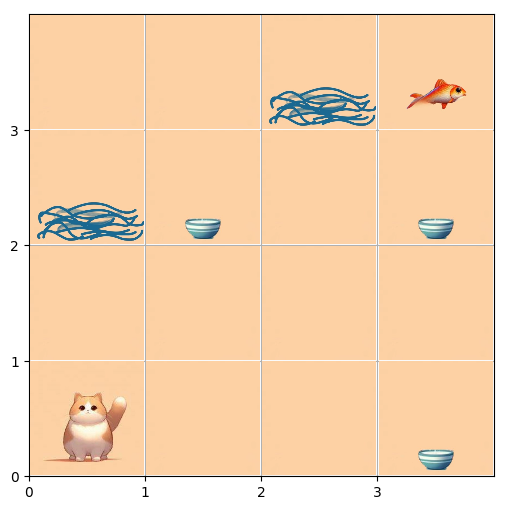

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 3 Down , Reward: -0.1 Truncated:  True , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


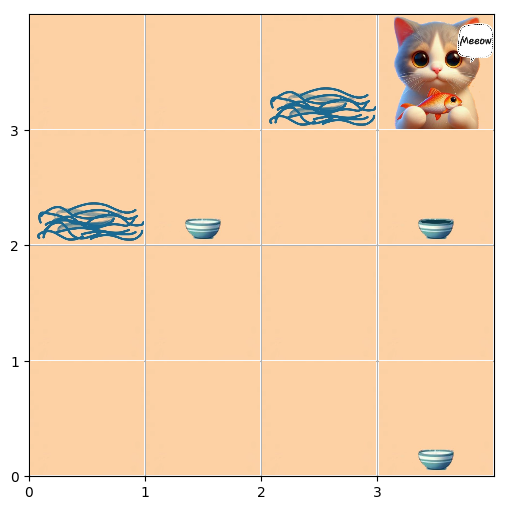

Total reward (Training):  3.4


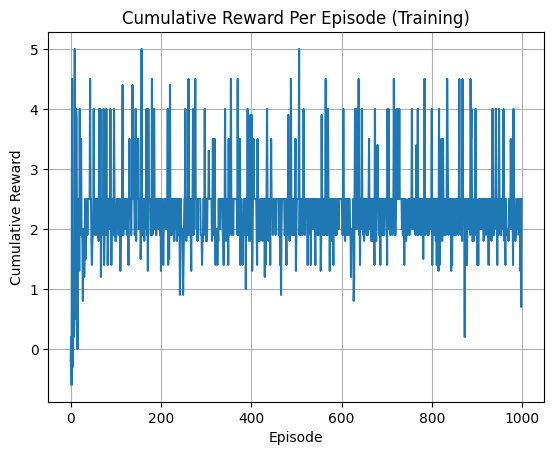

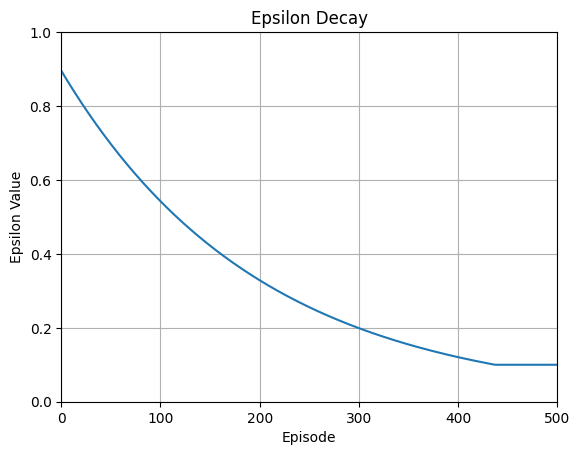

Total reward (Testing):  3.4


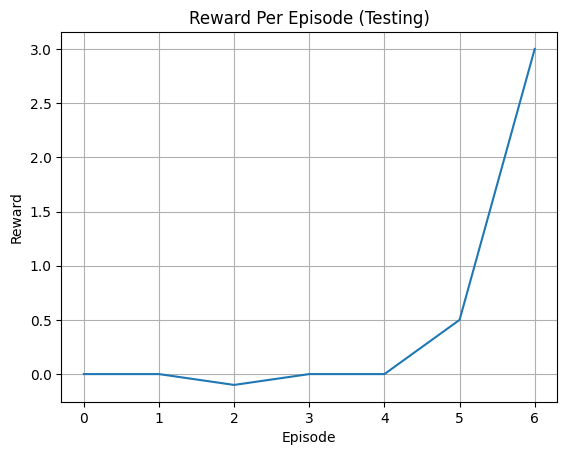

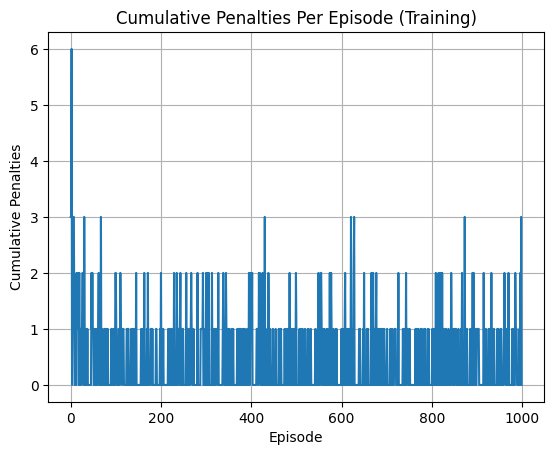

Average of Training penalties:  0.435
Test Penalties:  1


In [505]:
dql2 = run_dql(max_episodes=1000, gamma=0.9, decay_rate=0.995, epsilon_max=0.9, epsilon_min=0.1, alpha=0.01, max_timesteps=10)

Hyperparameter Tuning 3 -- Epsilon Decay Rate 3

Q-Table 1 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 2 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 1 After Training: 
[[ 3.58906296e-01  1.45328958e-02  0.00000000e+00  7.50336945e-03]
 [ 0.00000000e+00 -1.99000000e-03 -4.89200745e-02  3.42797379e-02]
 [ 1.48888406e-02  0.00000000e+00 -7.88130000e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.18650685e-01  2.31187019e-02 -1.26723073e-08  1.58160740e-02]
 [ 0.00000000e+00  0.00000000e+00  1.11885298e-01  4.04271000e-07]
 [ 1.09237473e-02 -9.95495039e-03

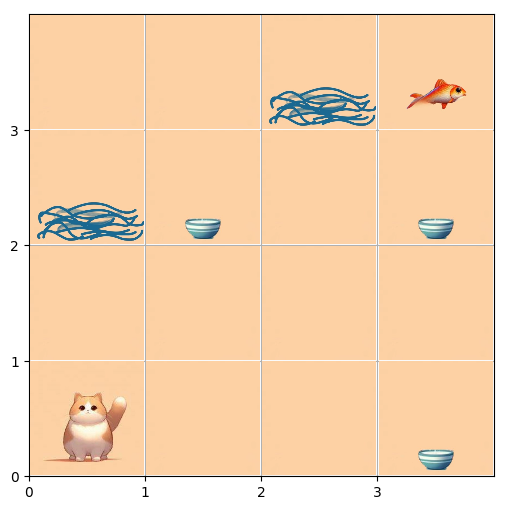

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: True
At the End:


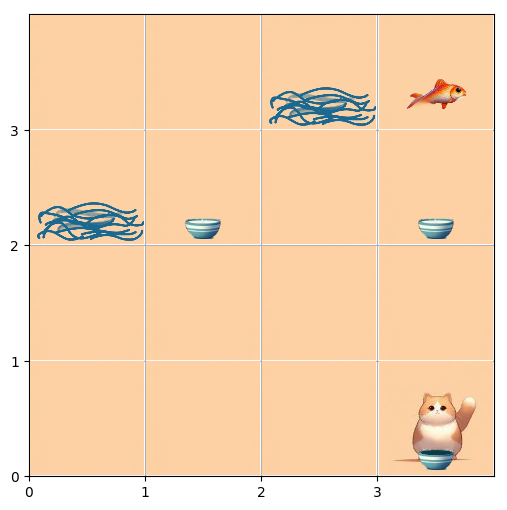

Total reward (Training):  0.5


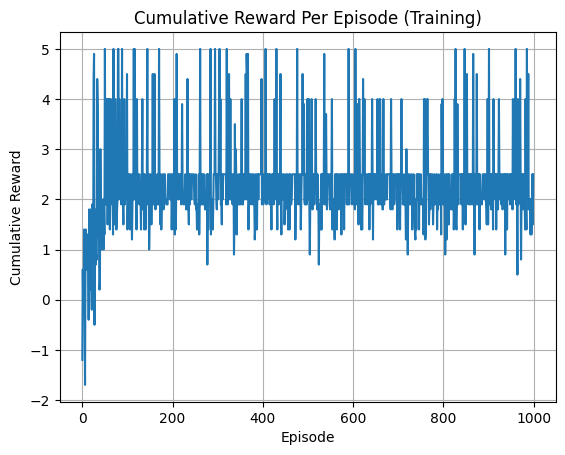

Total reward (Testing):  0.5


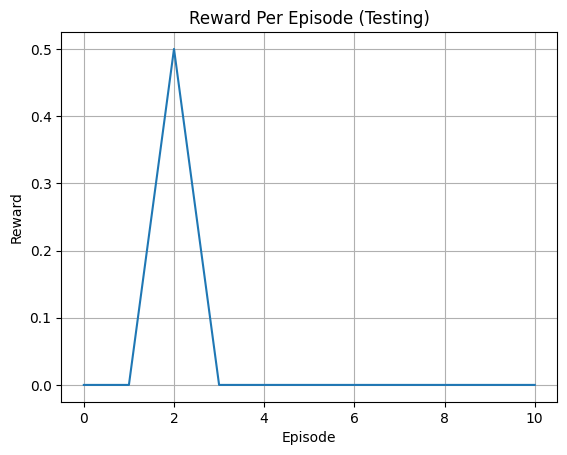

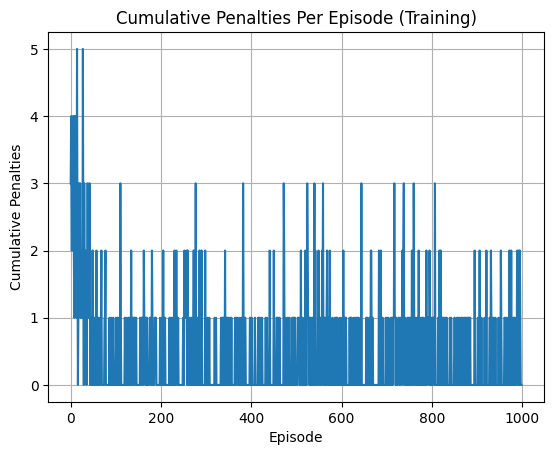

Average of Training penalties:  0.487
Test Penalties:  0


In [506]:
dql3 = run_dql(max_episodes=1000, gamma=0.9, decay_rate=0.998, epsilon_max=0.9, epsilon_min=0.1, alpha=0.01, max_timesteps=10)

Hyperparameter Tuning 4 -- Max timesteps 1

Q-Table 1 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 2 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 1 After Training: 
[[ 3.49634041e-01  1.24996001e-02  0.00000000e+00  1.63857584e-02]
 [-2.91289512e-09 -1.00000000e-03 -9.86603234e-03  2.64152065e-02]
 [ 3.87745737e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.60091657e-04 -1.00000000e-03 -1.00000000e-03 -1.00000000e-02]
 [ 3.86112512e-01  3.24171340e-02 -2.29894475e-08  2.92950256e-02]
 [ 0.00000000e+00  0.00000000e+00  1.26902064e-01  0.00000000e+00]
 [ 1.26078022e-02 -5.79924509e-02

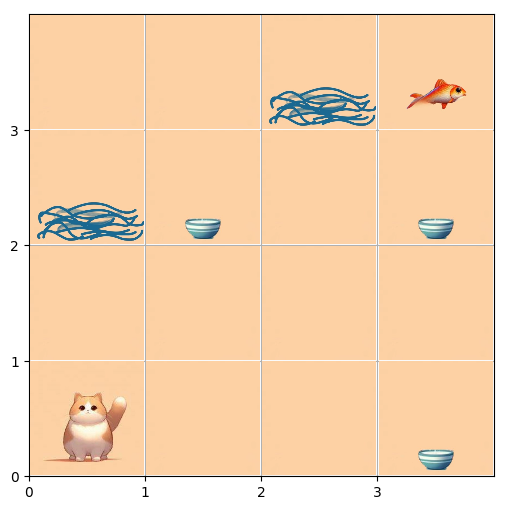

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


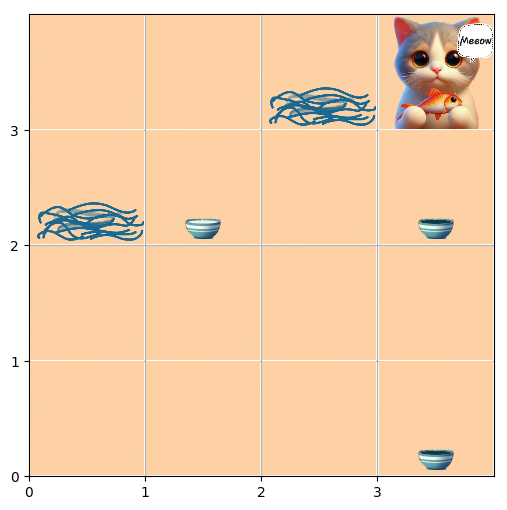

Total reward (Training):  4.0


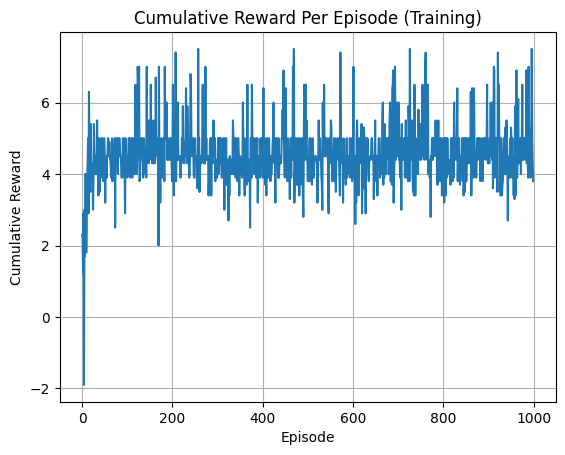

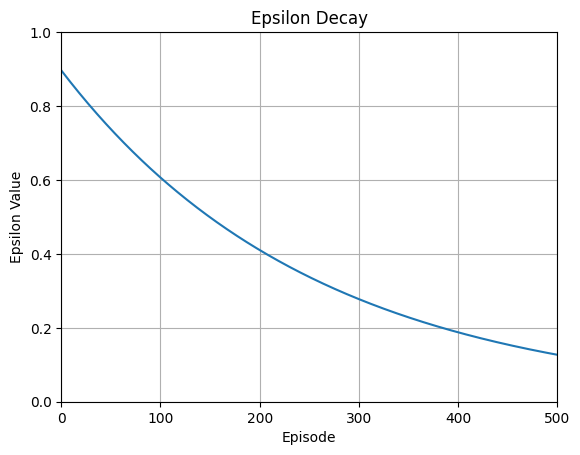

Total reward (Testing):  4.0


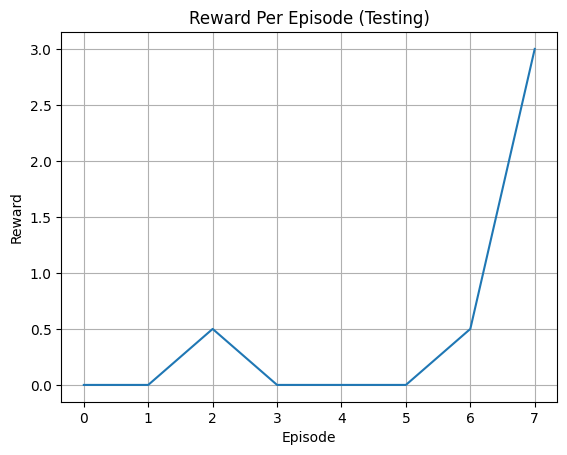

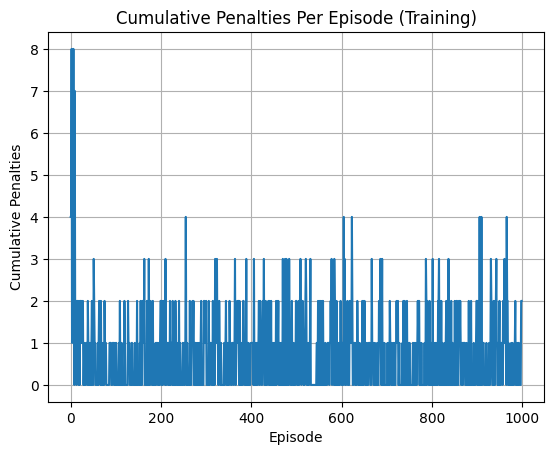

Average of Training penalties:  0.748
Test Penalties:  0


In [558]:
dql4 = run_dql(max_episodes=1000, gamma=0.9, decay_rate=0.9961, epsilon_max=0.9, epsilon_min=0.1, alpha=0.01, max_timesteps=20)

Hyperparameter Tuning 5 -- Max timesteps 2

Q-Table 1 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 2 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 1 After Training: 
[[ 3.47521008e-01  1.41494168e-02  0.00000000e+00  2.17351566e-02]
 [-7.35561000e-10 -1.00000000e-03 -1.98069179e-02  1.22257677e-02]
 [ 3.50363119e-02 -1.00000000e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e-03  0.00000000e+00 -1.99000000e-02]
 [ 3.85885773e-01  4.07184771e-02 -3.64110051e-09  1.76928690e-02]
 [ 0.00000000e+00  0.00000000e+00  1.60915698e-01  3.50148006e-03]
 [ 7.21402916e-02 -3.92702196e-02

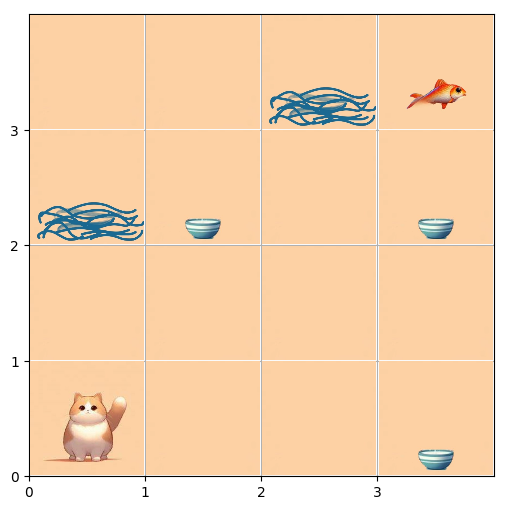

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0.5 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 3 Down , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 2 Up , Reward: 3 Truncated:  False , Done: True
At the End:


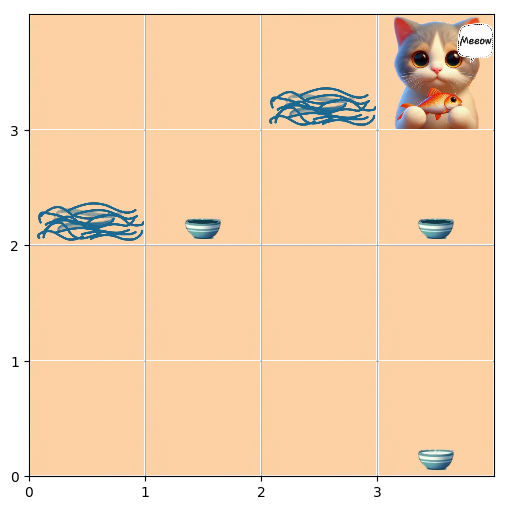

Total reward (Training):  4.0


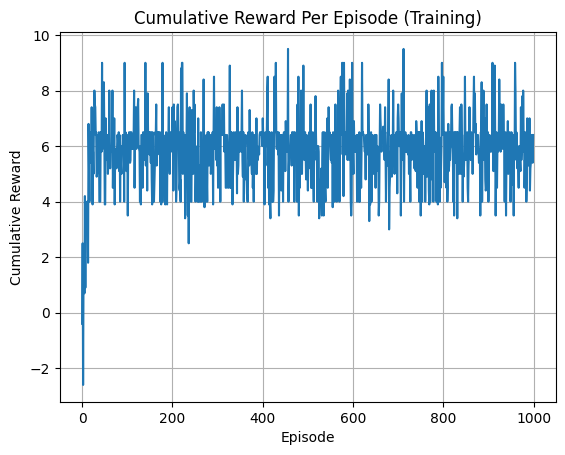

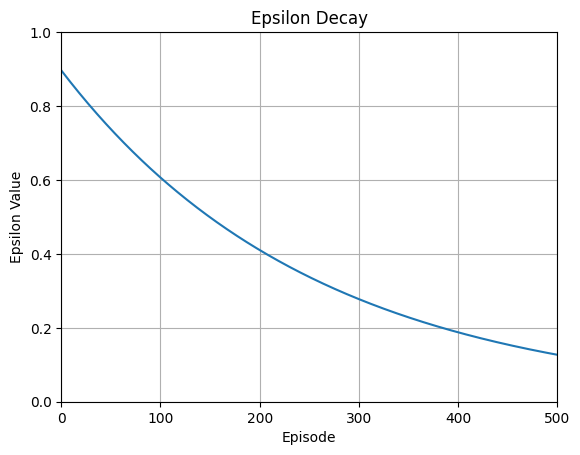

Total reward (Testing):  4.0


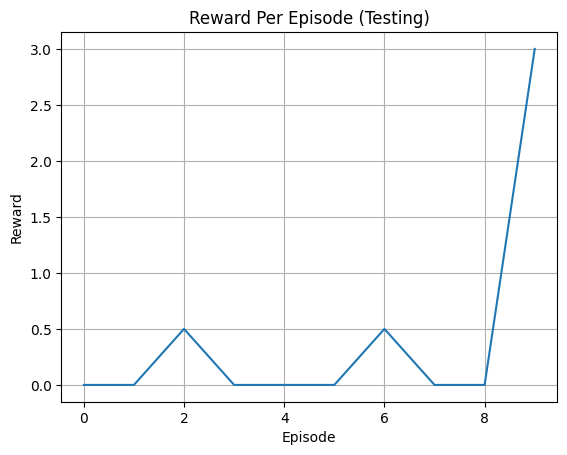

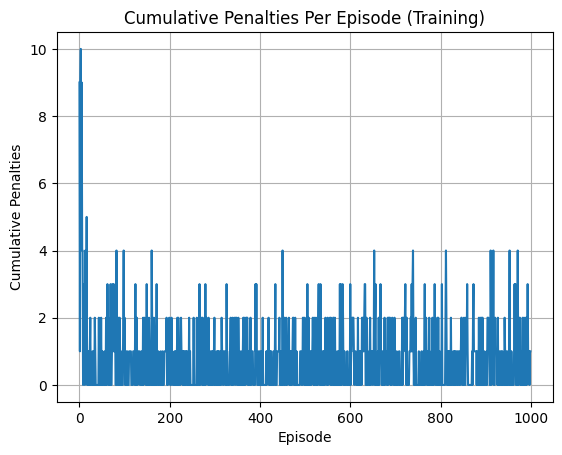

Average of Training penalties:  0.783
Test Penalties:  0


In [508]:
dql5 = run_dql(max_episodes=1000, gamma=0.9, decay_rate=0.9961, epsilon_max=0.9, epsilon_min=0.1, alpha=0.01, max_timesteps=27)

Hyperparameter Tuning 6 -- Max timesteps 3

Q-Table 1 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 2 Before Training: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Q-Table 1 After Training: 
[[ 3.29052064e-01  2.34913027e-02  0.00000000e+00  6.71284539e-03]
 [-3.60140580e-09  0.00000000e+00  0.00000000e+00  8.70002516e-03]
 [ 1.49396204e-02 -9.10450000e-04  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.00081000e-03  0.00000000e+00  0.00000000e+00]
 [ 3.49583115e-01  3.69340333e-02 -1.41909758e-08  4.45609148e-02]
 [ 0.00000000e+00  0.00000000e+00  1.80429373e-01  6.66612696e-03]
 [ 7.41693694e-02 -9.91045000e-03

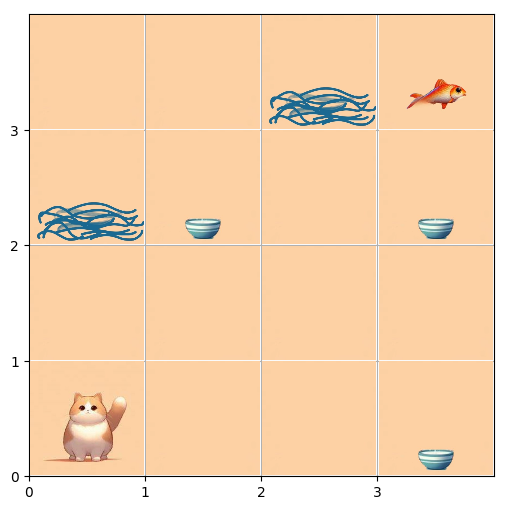

Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0.5 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 3 Down , Reward: -0.1 Truncated:  True , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 3 Down , Reward: -0.1 Truncated:  True , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 0 Right , Reward: 0 Truncated:  False , Done: False
Action: 1 Left , Reward: 0 Truncated:  False , Done: False
Action: 3 Down , Reward: -0.1 Truncated:  

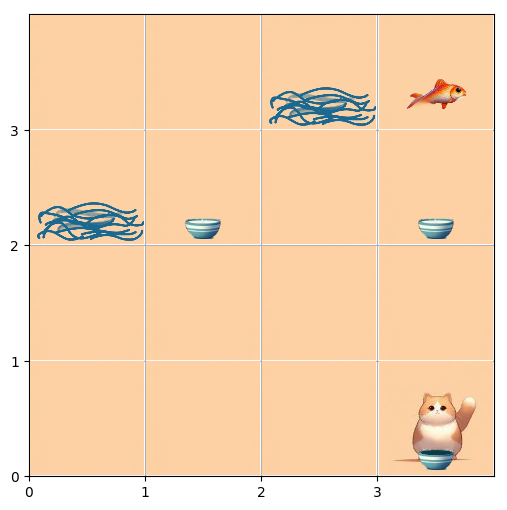

Total reward (Training):  0.20000000000000004


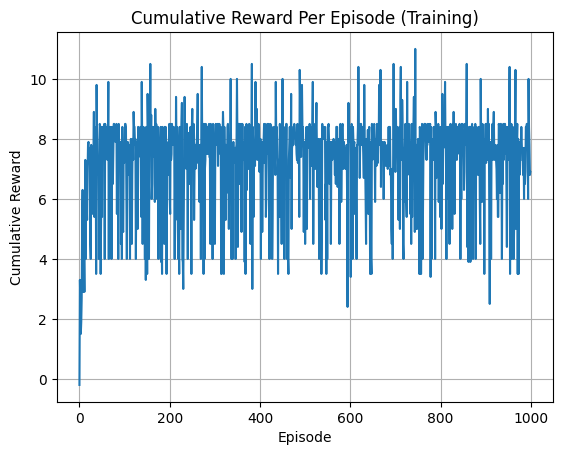

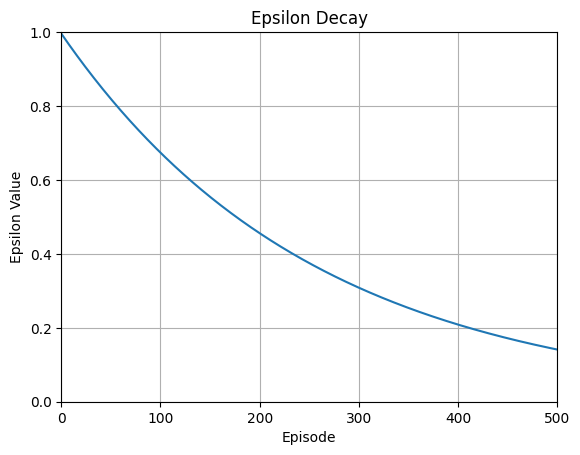

Total reward (Testing):  0.20000000000000004


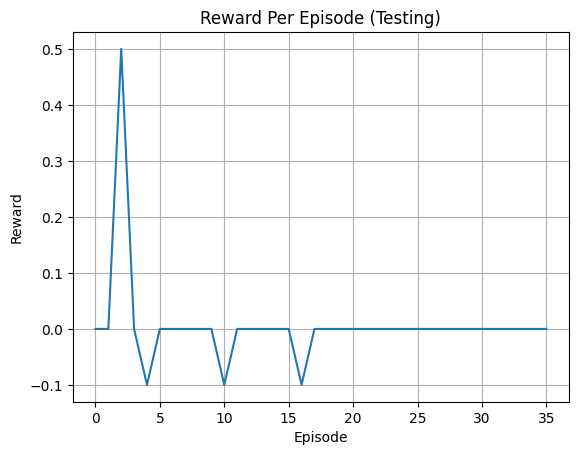

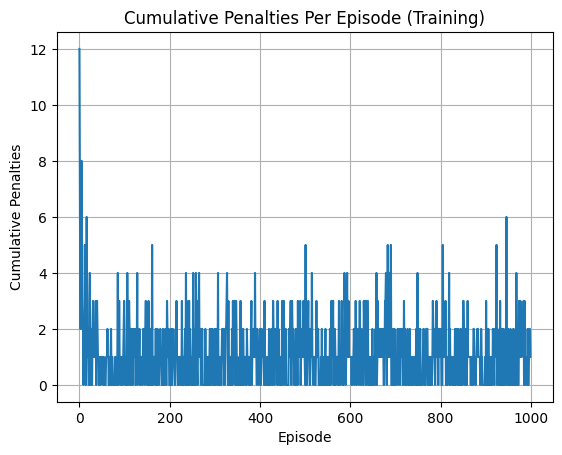

Average of Training penalties:  1.083
Test Penalties:  3


In [509]:
dql6 = run_dql(max_episodes=1000, gamma=0.9, decay_rate=0.9961, epsilon_max=1, epsilon_min=0.1, alpha=0.01, max_timesteps=35)

In [562]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(sarsa4.rewards, label='SARSA Rewards')
plt.plot(dql4.rewards, label='Double Q Learning Rewards', color='orange')

plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.title('Total Rewards comparison SARSA vs Double Q-Learning (Training)')
plt.legend() 
plt.grid()
plt.show()


In [510]:
#References
#I am using Prof. Alina code as my base code as it was mentioned in the assignment guidelines
#https://ubuffalo-my.sharepoint.com/:f:/g/personal/avereshc_buffalo_edu/Er0ESPRw4HFMjPpRokyJ7TYBPErfobIaPqritqkGpM1EOA?e=vgaaek
#https://ubuffalo-my.sharepoint.com/personal/avereshc_buffalo_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Favereshc%5Fbuffalo%5Fedu%2FDocuments%2F2023%5FFall%5FAI%2F%5Fpublic%2FCourse%20Materials%2FRL%20Environment%20Visualization%20by%20Nitin%20Kulkarni&ga=1

#I am using visualization code by Instructor Nitin Kulkarni as reference for visualizing environment 
#https://ubuffalo-my.sharepoint.com/:f:/g/personal/avereshc_buffalo_edu/Er0ESPRw4HFMjPpRokyJ7TYBPErfobIaPqritqkGpM1EOA?e=vgaaek
#https://ubuffalo-my.sharepoint.com/personal/avereshc_buffalo_edu/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Favereshc%5Fbuffalo%5Fedu%2FDocuments%2F2023%5FFall%5FAI%2F%5Fpublic%2FCourse%20Materials%2FRL%20Environment%20Visualization%20by%20Nitin%20Kulkarni%2Fvisualizing%5Frl%5Fenvironments%5Fand%5Frepresenting%5Fthe%5Fresults%20%282%29%2Ezip&parent=%2Fpersonal%2Favereshc%5Fbuffalo%5Fedu%2FDocuments%2F2023%5FFall%5FAI%2F%5Fpublic%2FCourse%20Materials%2FRL%20Environment%20Visualization%20by%20Nitin%20Kulkarni

#I took the help of Microsoft Copilot powered by DALLE - E to generate main components of the images of my environment and created the remaining using those component images.
# https://gymnasium.farama.org/api/env/
# https://www.gymlibrary.dev/api/spaces/
# https://numpy.org/doc/stable/reference/index.html#reference